In [177]:
import glob
from typing import List

import matplotlib.pyplot as plt
import pandas as pd

In [178]:
seed = 8
dataset = "cifar"
train_dirs = glob.glob(f"train/{dataset}/*")
results_dirs = glob.glob(f"results/{dataset}/*")
configs = [
    f"{quantizer}_{bit}"
    for quantizer in ["lin", "lin+", "po2", "po2+"]
    for bit in [2, 3, 4]
]
config_pairs = [
    (f"{train}_{quantizer}_{bit}", f"{train}_{quantizer}+_{bit}")
    for train in ["ptq", "qat"]
    for quantizer in ["lin", "po2"]
    for bit in [2, 3, 4]
]
color_map = {
    "po2": "red",
    "po2+": "orange",
    "lin": "blue",
    "lin+": "purple",
}

In [179]:
def calculate_mean_and_std(lists: List[pd.DataFrame]):
    df_concat = pd.concat(lists)
    by_row_index = df_concat.groupby(df_concat.index)
    return by_row_index.mean(), by_row_index.std()

## Full Precision Train Curves


In [180]:
def plot_full_precision_training(metric: str, label: str):
    models = []
    for train_dir in train_dirs:
        seeds = glob.glob(f"{train_dir}/*")
        dfs = []
        for seed in seeds:
            df = pd.read_csv(f"{seed}/full_precision.csv")
            dfs.append(df)

        # just take the average across all training seeds
        mean_df, _ = calculate_mean_and_std(dfs)
        model_name = train_dir.split("/")[-1]
        models.append((model_name, mean_df))

    _, ax = plt.subplots(figsize=(10, 6), dpi=300)

    for model_name, df in models:
        ax.plot(df["epoch"], df[metric], label=model_name)

    ax.set_title(f"Full Precision Training: {label}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel(label)
    ax.legend()
    plt.show()

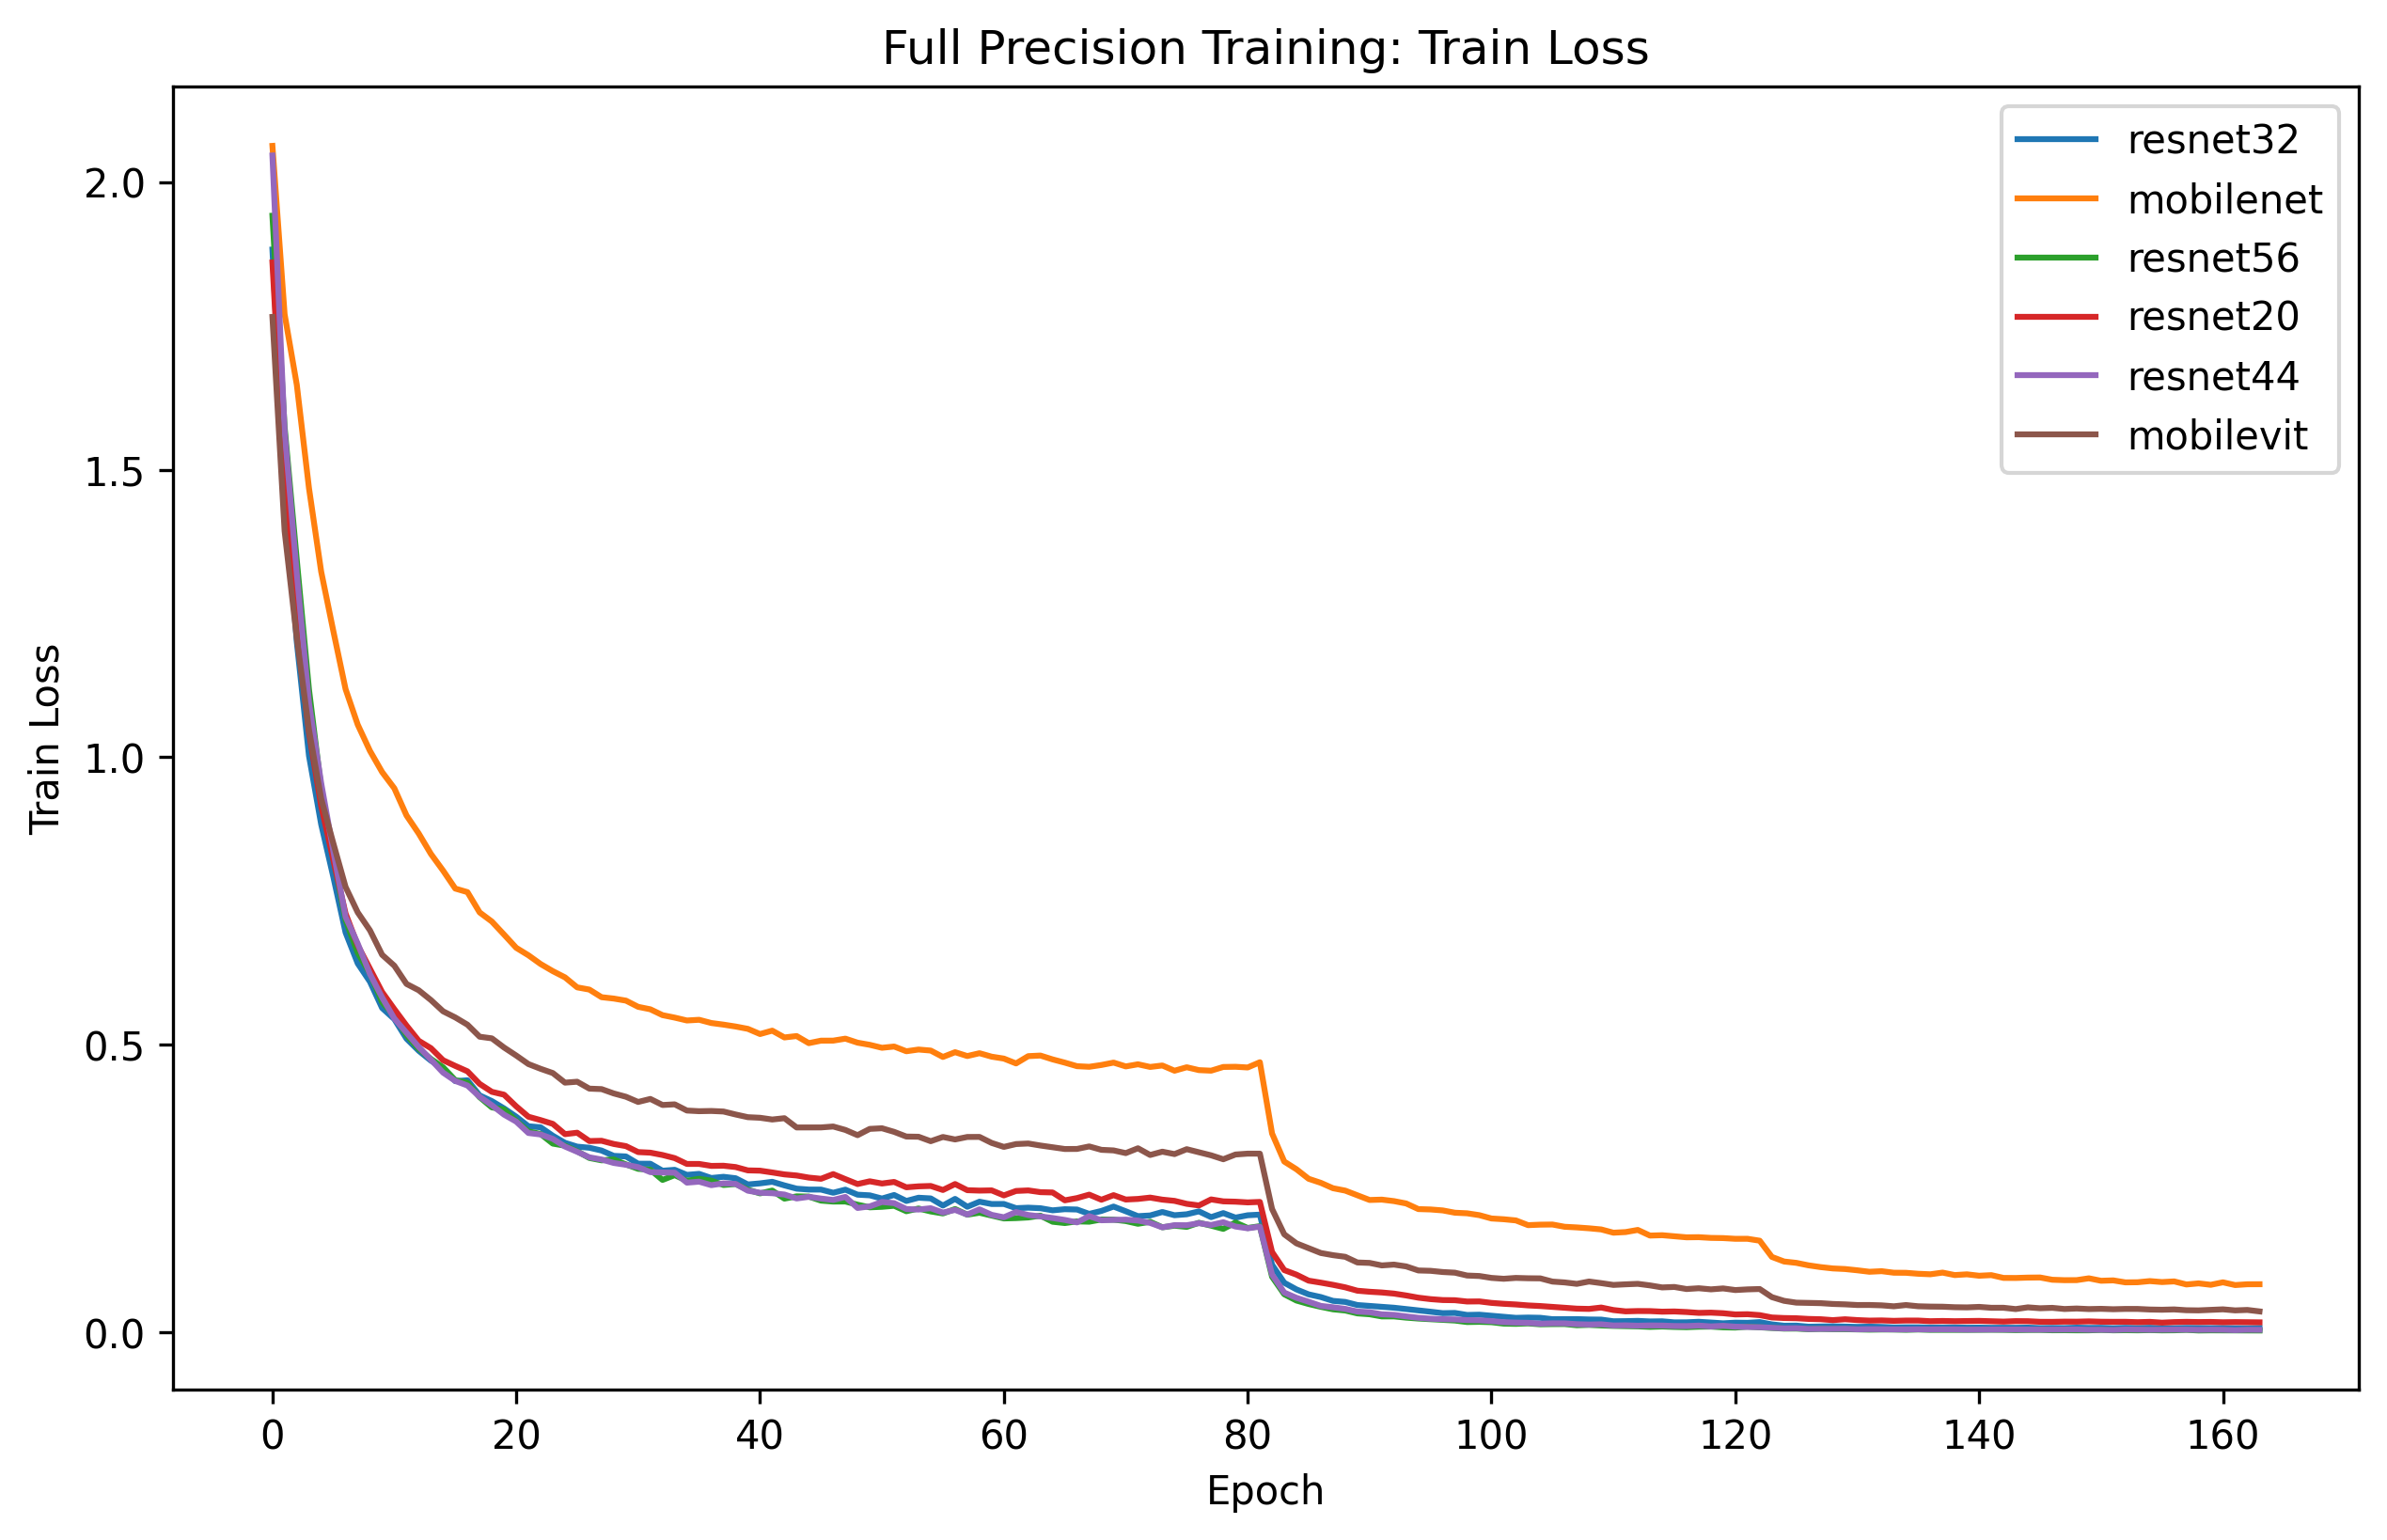

In [181]:
plot_full_precision_training("train_loss", "Train Loss")

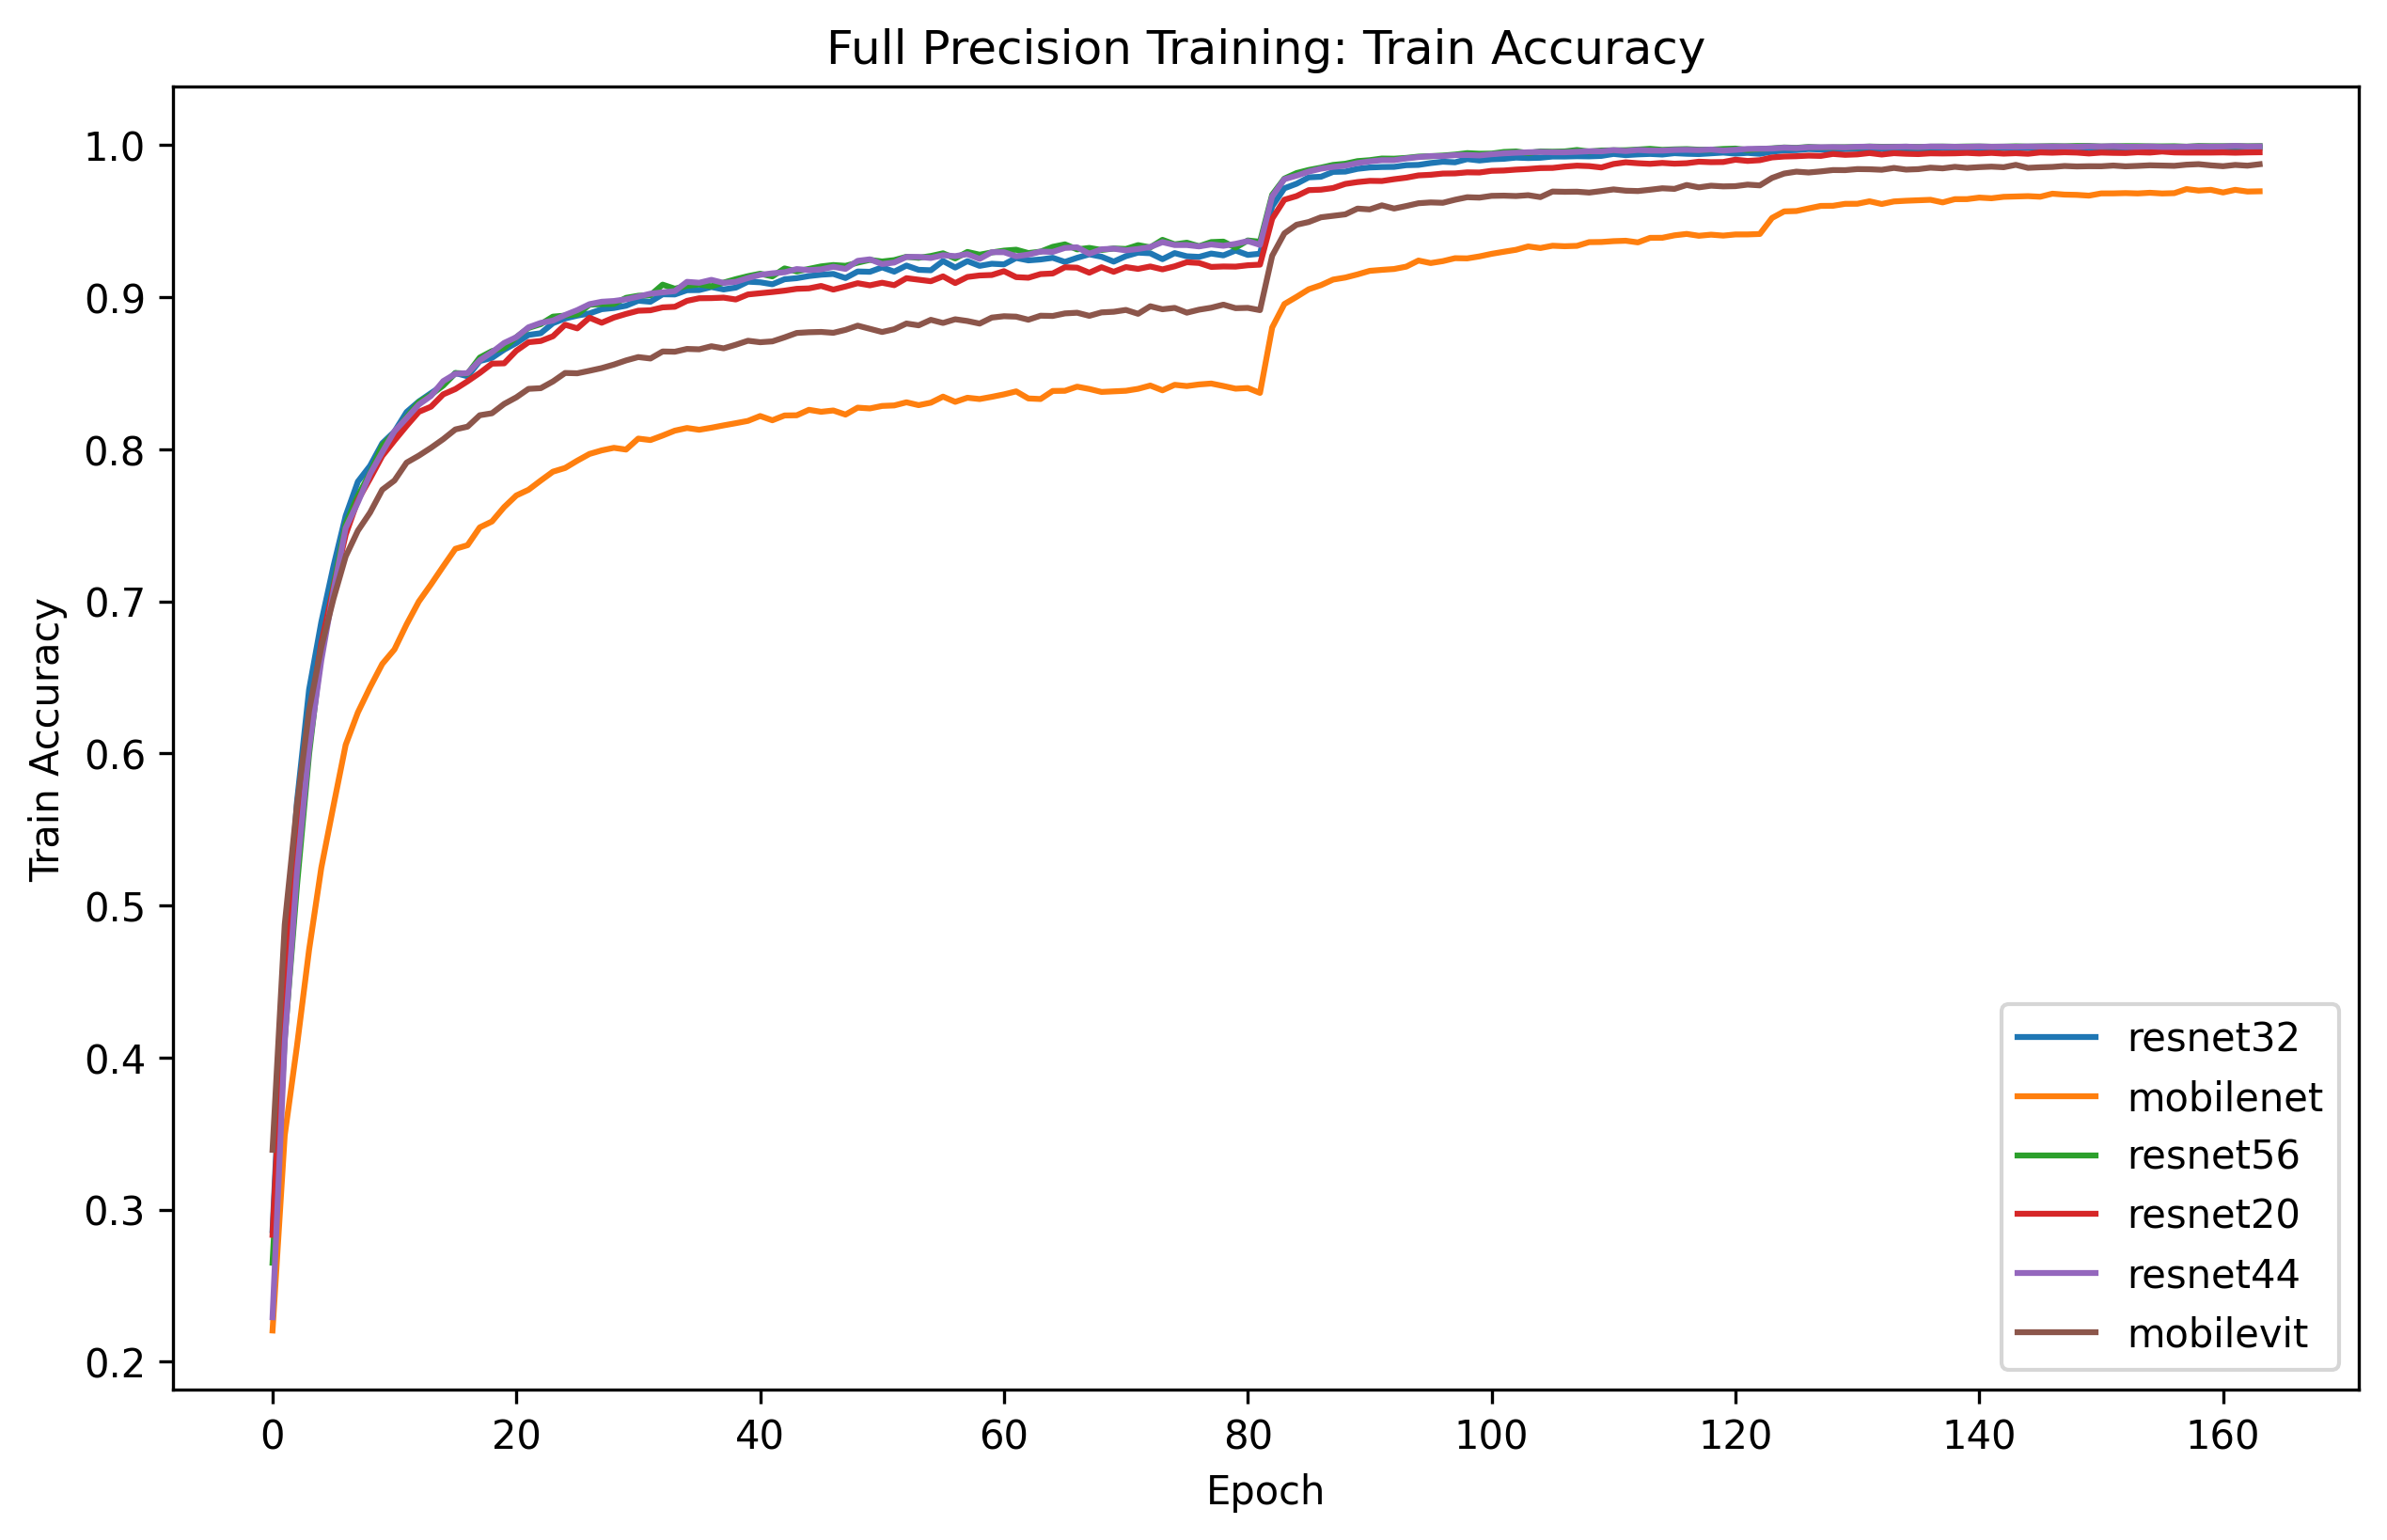

In [182]:
plot_full_precision_training("train_acc", "Train Accuracy")

## QAT Train Cruves: ResNet20


In [183]:
def plot_qat_training(metric: str, label: str, model_name: str):
    train_configs = []
    seeds = glob.glob(f"train/{dataset}/{model_name}/*")

    for config in configs:
        dfs = []
        for seed in seeds:
            df = pd.read_csv(f"{seed}/{config}.csv")
            dfs.append(df)

        # just take the average across all training seeds
        mean_df, _ = calculate_mean_and_std(dfs)
        train_configs.append((config, mean_df))

    _, ax = plt.subplots(figsize=(10, 6), dpi=300)

    for train_config, df in train_configs:
        color = color_map[train_config.split("_")[0]]
        ax.plot(df["epoch"], df[metric], label=config, color=color)

    ax.set_title(f"QAT {label}: {model_name}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel(label)
    ax.legend()
    plt.show()

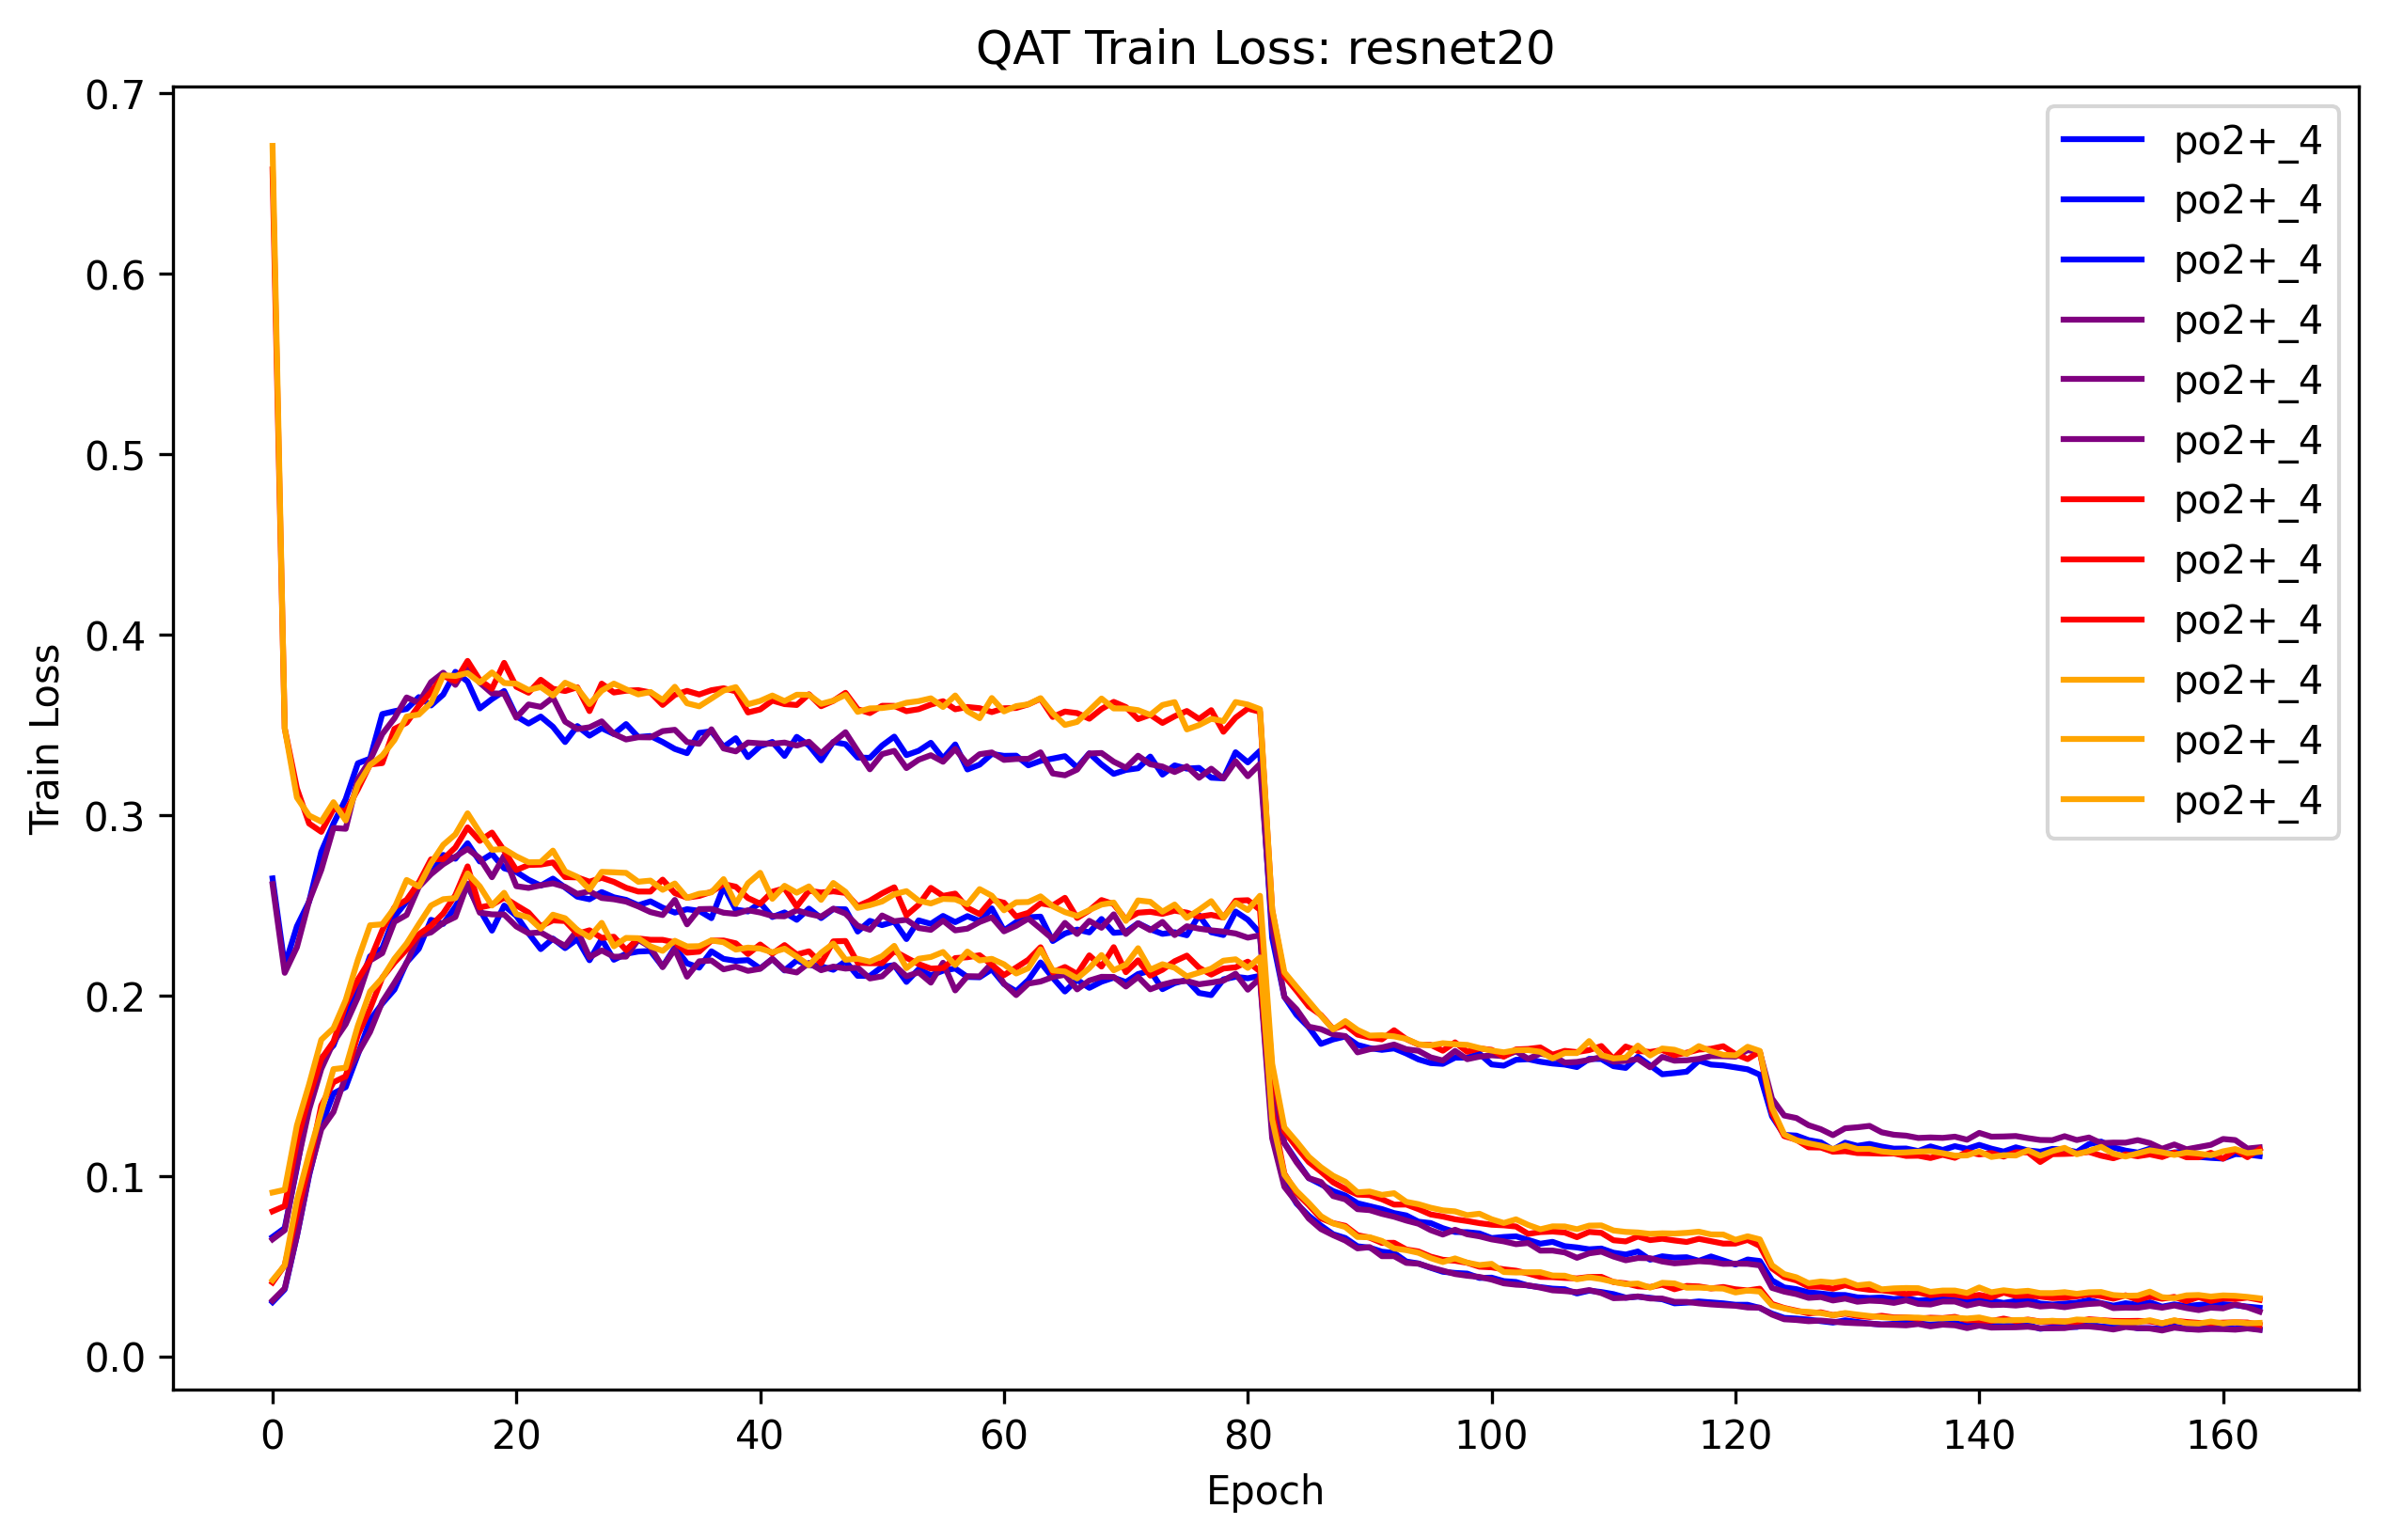

In [184]:
plot_qat_training("train_loss", "Train Loss", "resnet20")

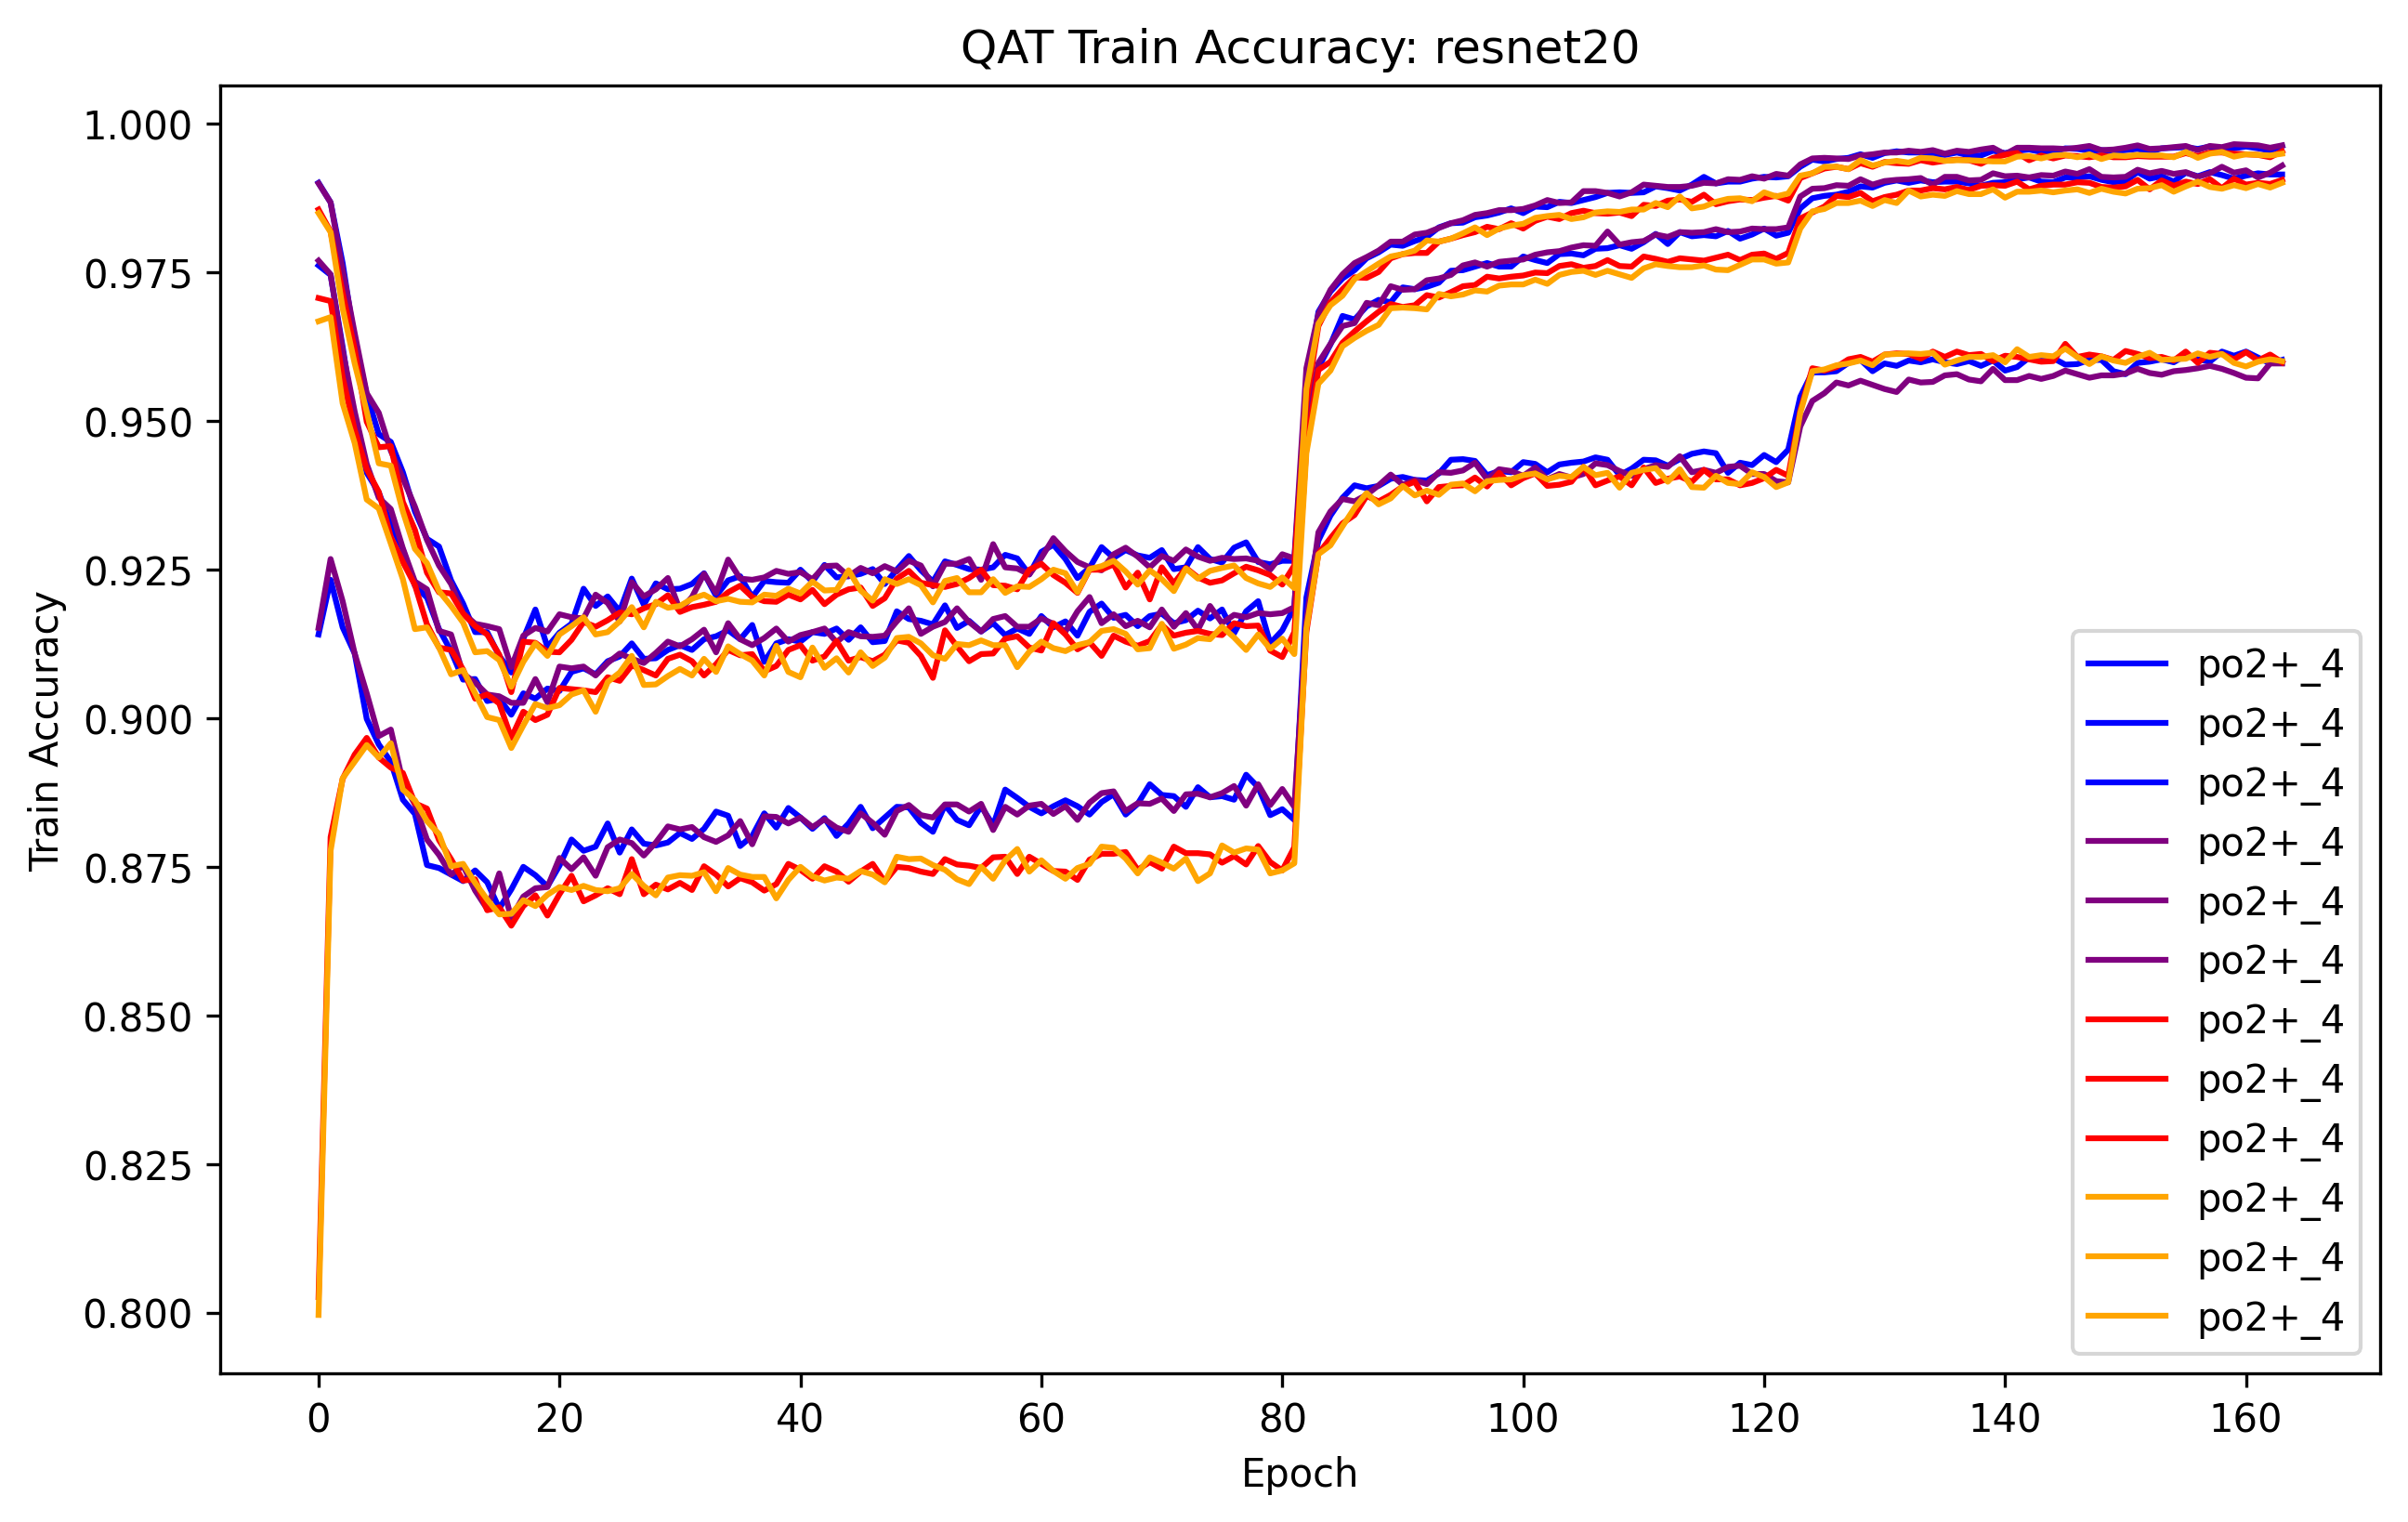

In [185]:
plot_qat_training("train_acc", "Train Accuracy", "resnet20")

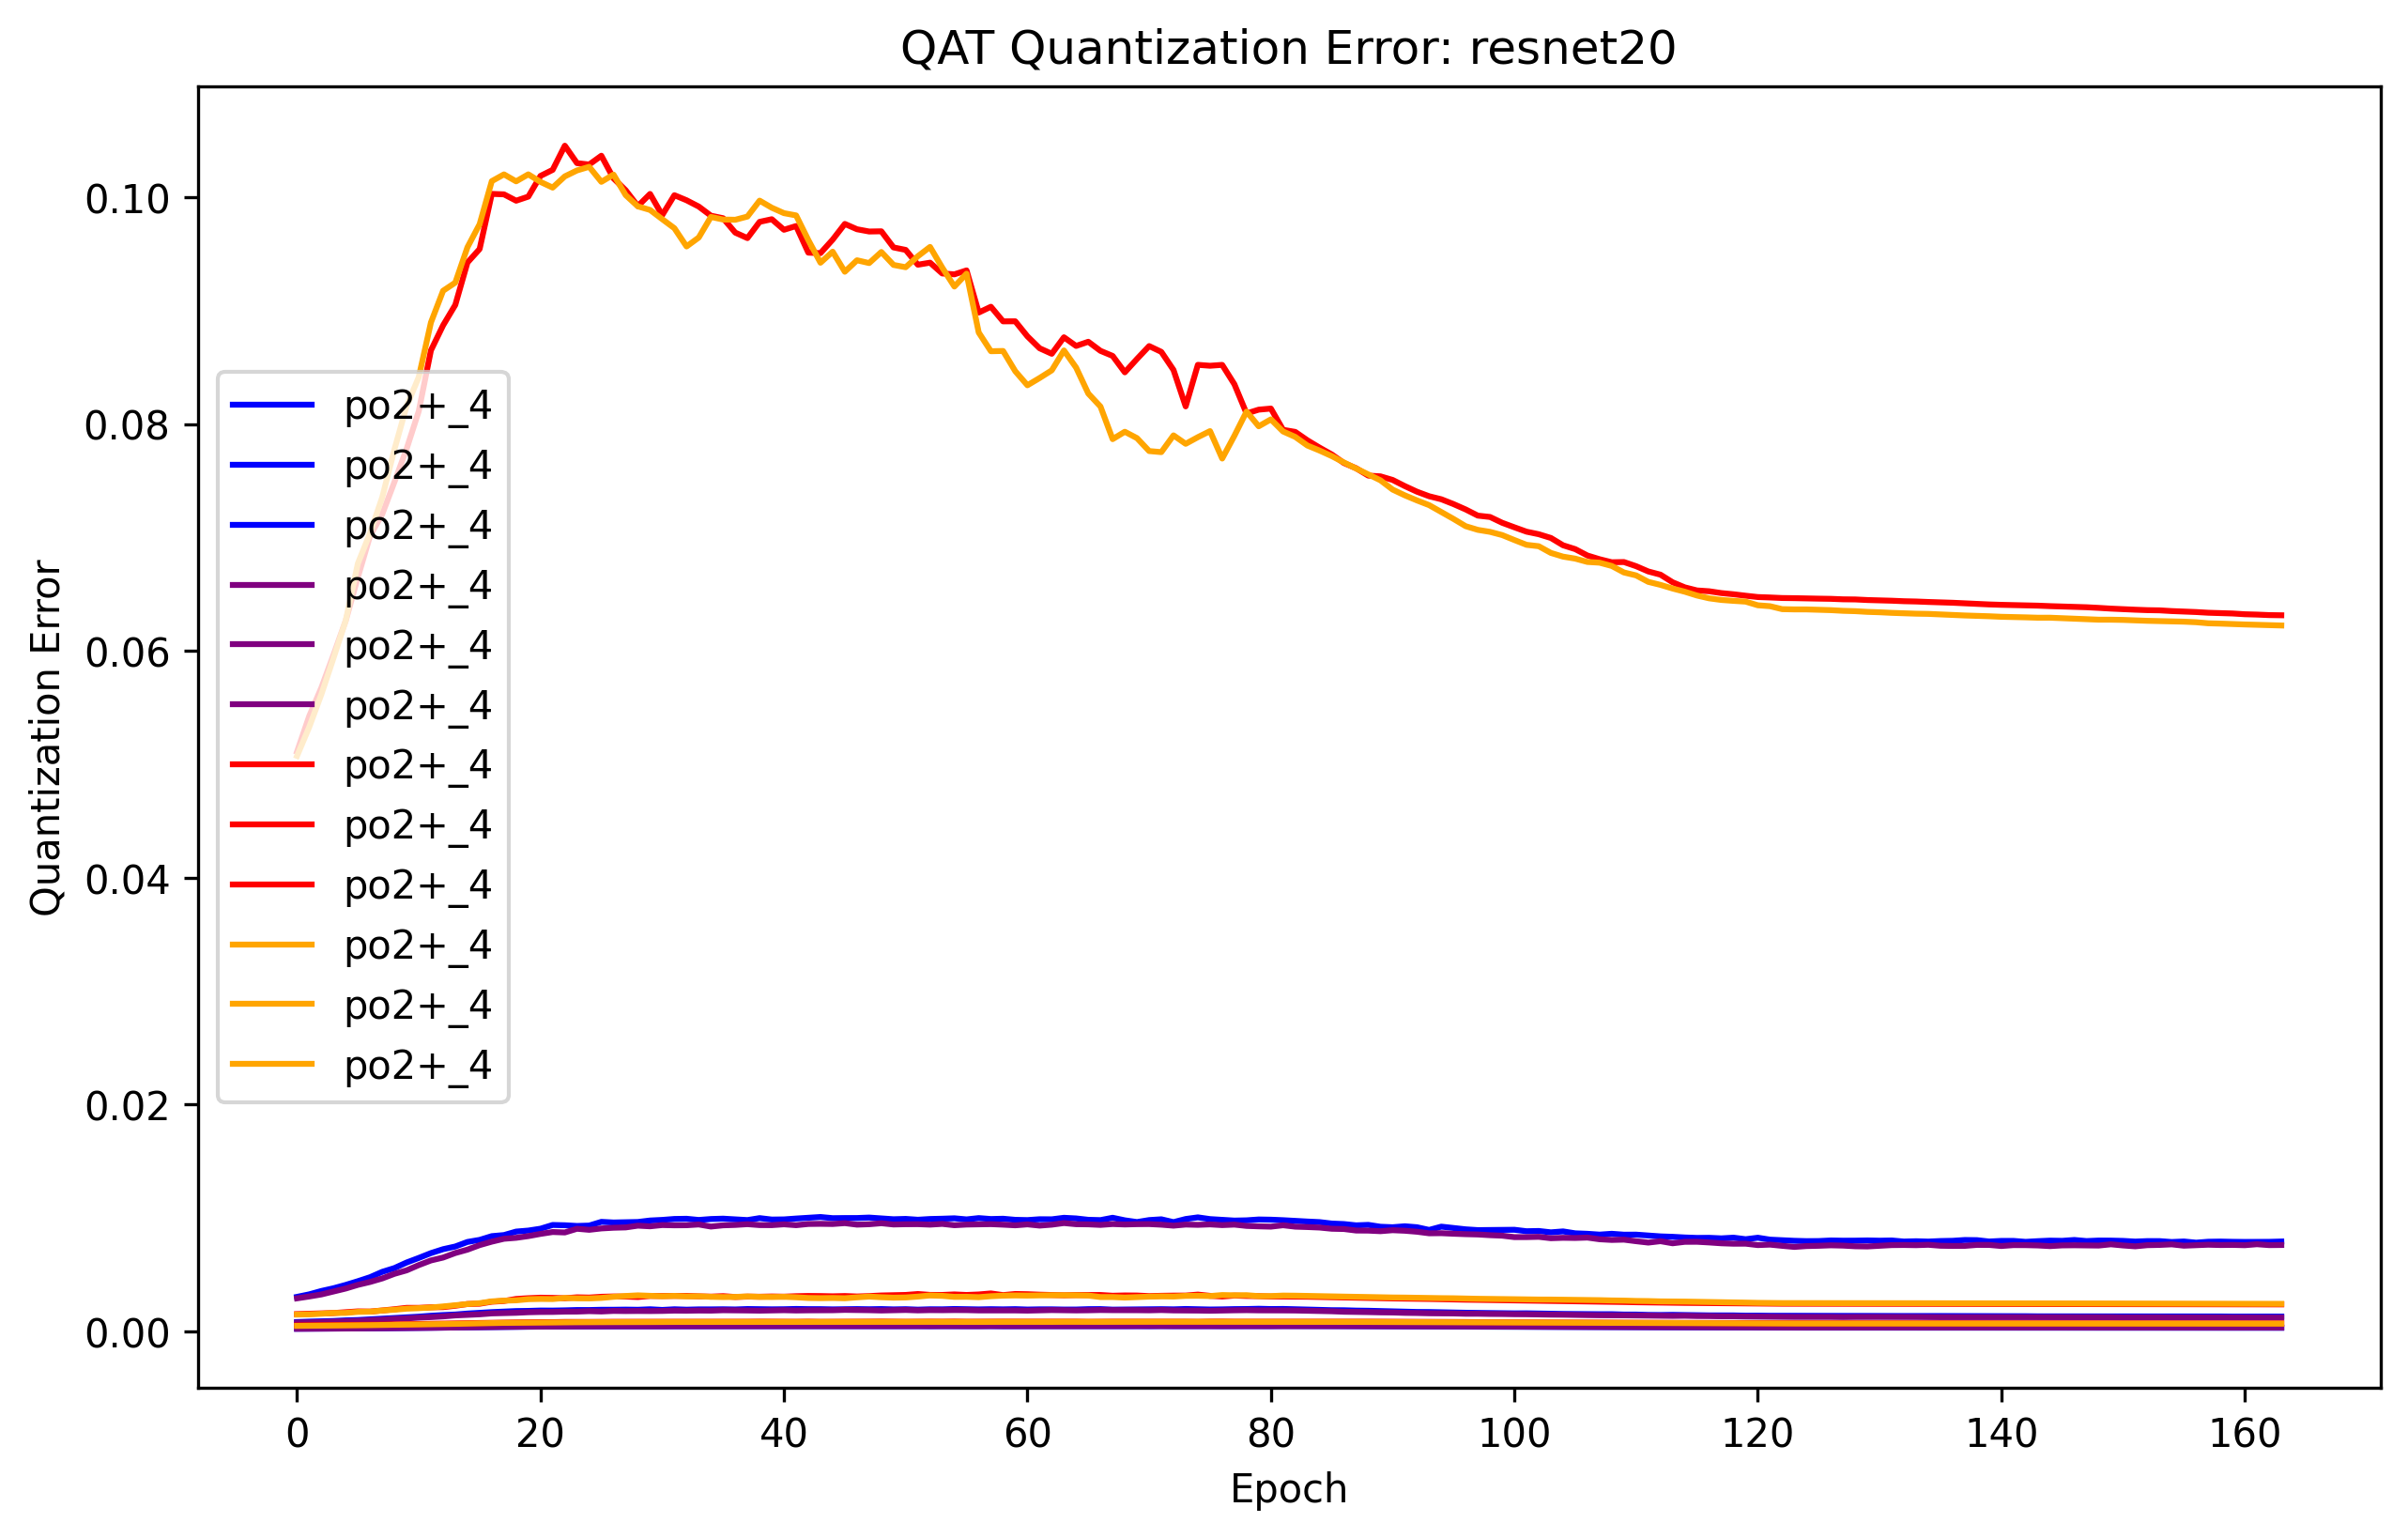

In [186]:
plot_qat_training("quantization_error", "Quantization Error", "resnet20")

### Calculate Percent Change in Quantization Errors


In [191]:
def calculate_percent_change(metric: str):
    results = {"model": [], "quantizer": [], "percent_change": []}

    for results_dir in results_dirs:
        model_type = results_dir.split("/")[-1]
        df = pd.read_csv(f"{results_dir}/{seed}.csv")
        for before, after in config_pairs:
            metric_before = df.loc[df["model"] == before][metric].values[0]
            metric_after = df.loc[df["model"] == after][metric].values[0]
            percent_change = 100 * (metric_after - metric_before) / metric_before
            if percent_change > 100 or percent_change < -100:
                percent_change = None
            if metric == "test_acc" and (metric_before < 0.12 or metric_after < 0.12):
                percent_change = None
            results["model"].append(model_type)
            results["quantizer"].append(after)
            results["percent_change"].append(percent_change)

    df = pd.DataFrame(results)
    return df.pivot(index="quantizer", columns="model", values="percent_change")

In [192]:
calculate_percent_change("quantization_error")

model       mobilenet  mobilevit  resnet20  resnet32  resnet44  resnet56
quantizer                                                               
ptq_lin+_2  -5.977245  -6.789602 -3.657326 -5.431130 -5.607396 -6.635437
ptq_lin+_3  -0.968011  -1.848329 -8.151649 -2.618286 -4.325679 -4.943764
ptq_lin+_4   6.725359   3.739956 -1.180277  1.284250  1.269855  0.726817
ptq_po2+_2  -0.029731  -0.012889 -0.011309 -0.007362 -0.008672 -0.005753
ptq_po2+_3  -3.293826  -1.816544 -3.066638 -2.675548 -2.622548 -2.282772
ptq_po2+_4  -8.349850  -8.310821 -8.413704 -8.433851 -8.587378 -8.414649
qat_lin+_2        NaN -94.186980 -5.208413 -3.607316 -4.924552 -3.960466
qat_lin+_3  -6.152323  -5.157057 -5.748330 -3.936286 -2.979451 -3.738994
qat_lin+_4   9.041651   9.316806  2.486855  2.691110  2.444660  2.260195
qat_po2+_2   2.961748  -1.728609 -1.369046  0.896530 -6.850894 -0.102261
qat_po2+_3   1.315910  -0.221762  0.353106  5.890473  7.138682  4.698951
qat_po2+_4  -5.346934  -9.253387 -3.029202 -3.076901 -3.407885 -2.993170

In [193]:
calculate_percent_change("test_acc")

model       mobilenet  mobilevit  resnet20   resnet32   resnet44  resnet56
quantizer                                                                 
ptq_lin+_2  15.111940        NaN       NaN -24.666360 -15.448069       NaN
ptq_lin+_3  -1.062106  -3.560000 -6.074528  -2.656104  -9.219858 -5.735632
ptq_lin+_4  -0.228455  -7.527135 -1.474531  -0.296899  -0.581332 -1.361440
ptq_po2+_2        NaN        NaN       NaN        NaN        NaN       NaN
ptq_po2+_3   3.549552  32.583436  2.775196   4.649340   5.224148  2.011862
ptq_po2+_4  -0.810701   1.780120  1.320056  -1.331990   2.470111 -1.049492
qat_lin+_2        NaN        NaN -3.665965   0.032605   0.303622 -0.150992
qat_lin+_3  -7.100035   1.320095 -0.205850   0.000000   0.032241 -0.629266
qat_lin+_4  -1.949928  -0.442136 -0.227840   0.150976  -0.053642  0.021379
qat_po2+_2  -3.683471   1.709091  1.308960  -0.054987   0.141767 -0.075988
qat_po2+_3 -14.641745  -0.157480  0.130961   0.183804  -0.214707 -0.288894
qat_po2+_4   2.383532  -0.165966  0.108921  -0.161533   0.322928  0.106940

In [194]:
def get_results(model_name: str, y_min: float, y_max: float, qat: bool):
    df = pd.read_csv(f"results/{dataset}/{model_name}/{seed}.csv")
    full_precision_acc = df.loc[df["model"] == "full_precision", "test_acc"].values[0]

    df[["type", "quantizer", "bits"]] = df["model"].str.split("_", expand=True)
    df = df.pivot_table(index=["type", "bits"], columns="quantizer", values="test_acc")

    df["lin+ (%)"] = round(100 * (df["lin+"] - df["lin"]) / df["lin"], 2)
    df["po2+ (%)"] = round(100 * (df["po2+"] - df["po2"]) / df["po2"], 2)

    column_order = [
        "lin",
        "lin+",
        "lin+ (%)",
        "po2",
        "po2+",
        "po2+ (%)",
    ]
    df = df.reindex(columns=column_order)

    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    linestyles = {"": "-", "+": "--"}
    qtype = "qat" if qat else "ptq"
    for quantizer in ["lin", "lin+", "po2", "po2+"]:
        accuracies = df.loc[qtype][quantizer].values
        bits = df.loc[qtype].index.astype(int)
        linestyle = linestyles["+" if "+" in quantizer else ""]
        ax.plot(bits, accuracies, marker="o", linestyle=linestyle, label=quantizer)

    ax.axhline(
        full_precision_acc,
        color="black",
        linestyle="--",
        label="Full Precision",
    )

    ax.set_xlabel("Number of Bits")
    ax.set_ylabel("Accuracy")
    ax.set_title(
        f"Test Accuracy: {model_name} QAT"
        if qat
        else f"Test Accuracy: {model_name} PTQ"
    )
    ax.set_xticks([2, 3, 4])
    ax.set_ylim(y_min, y_max)
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()
    return df

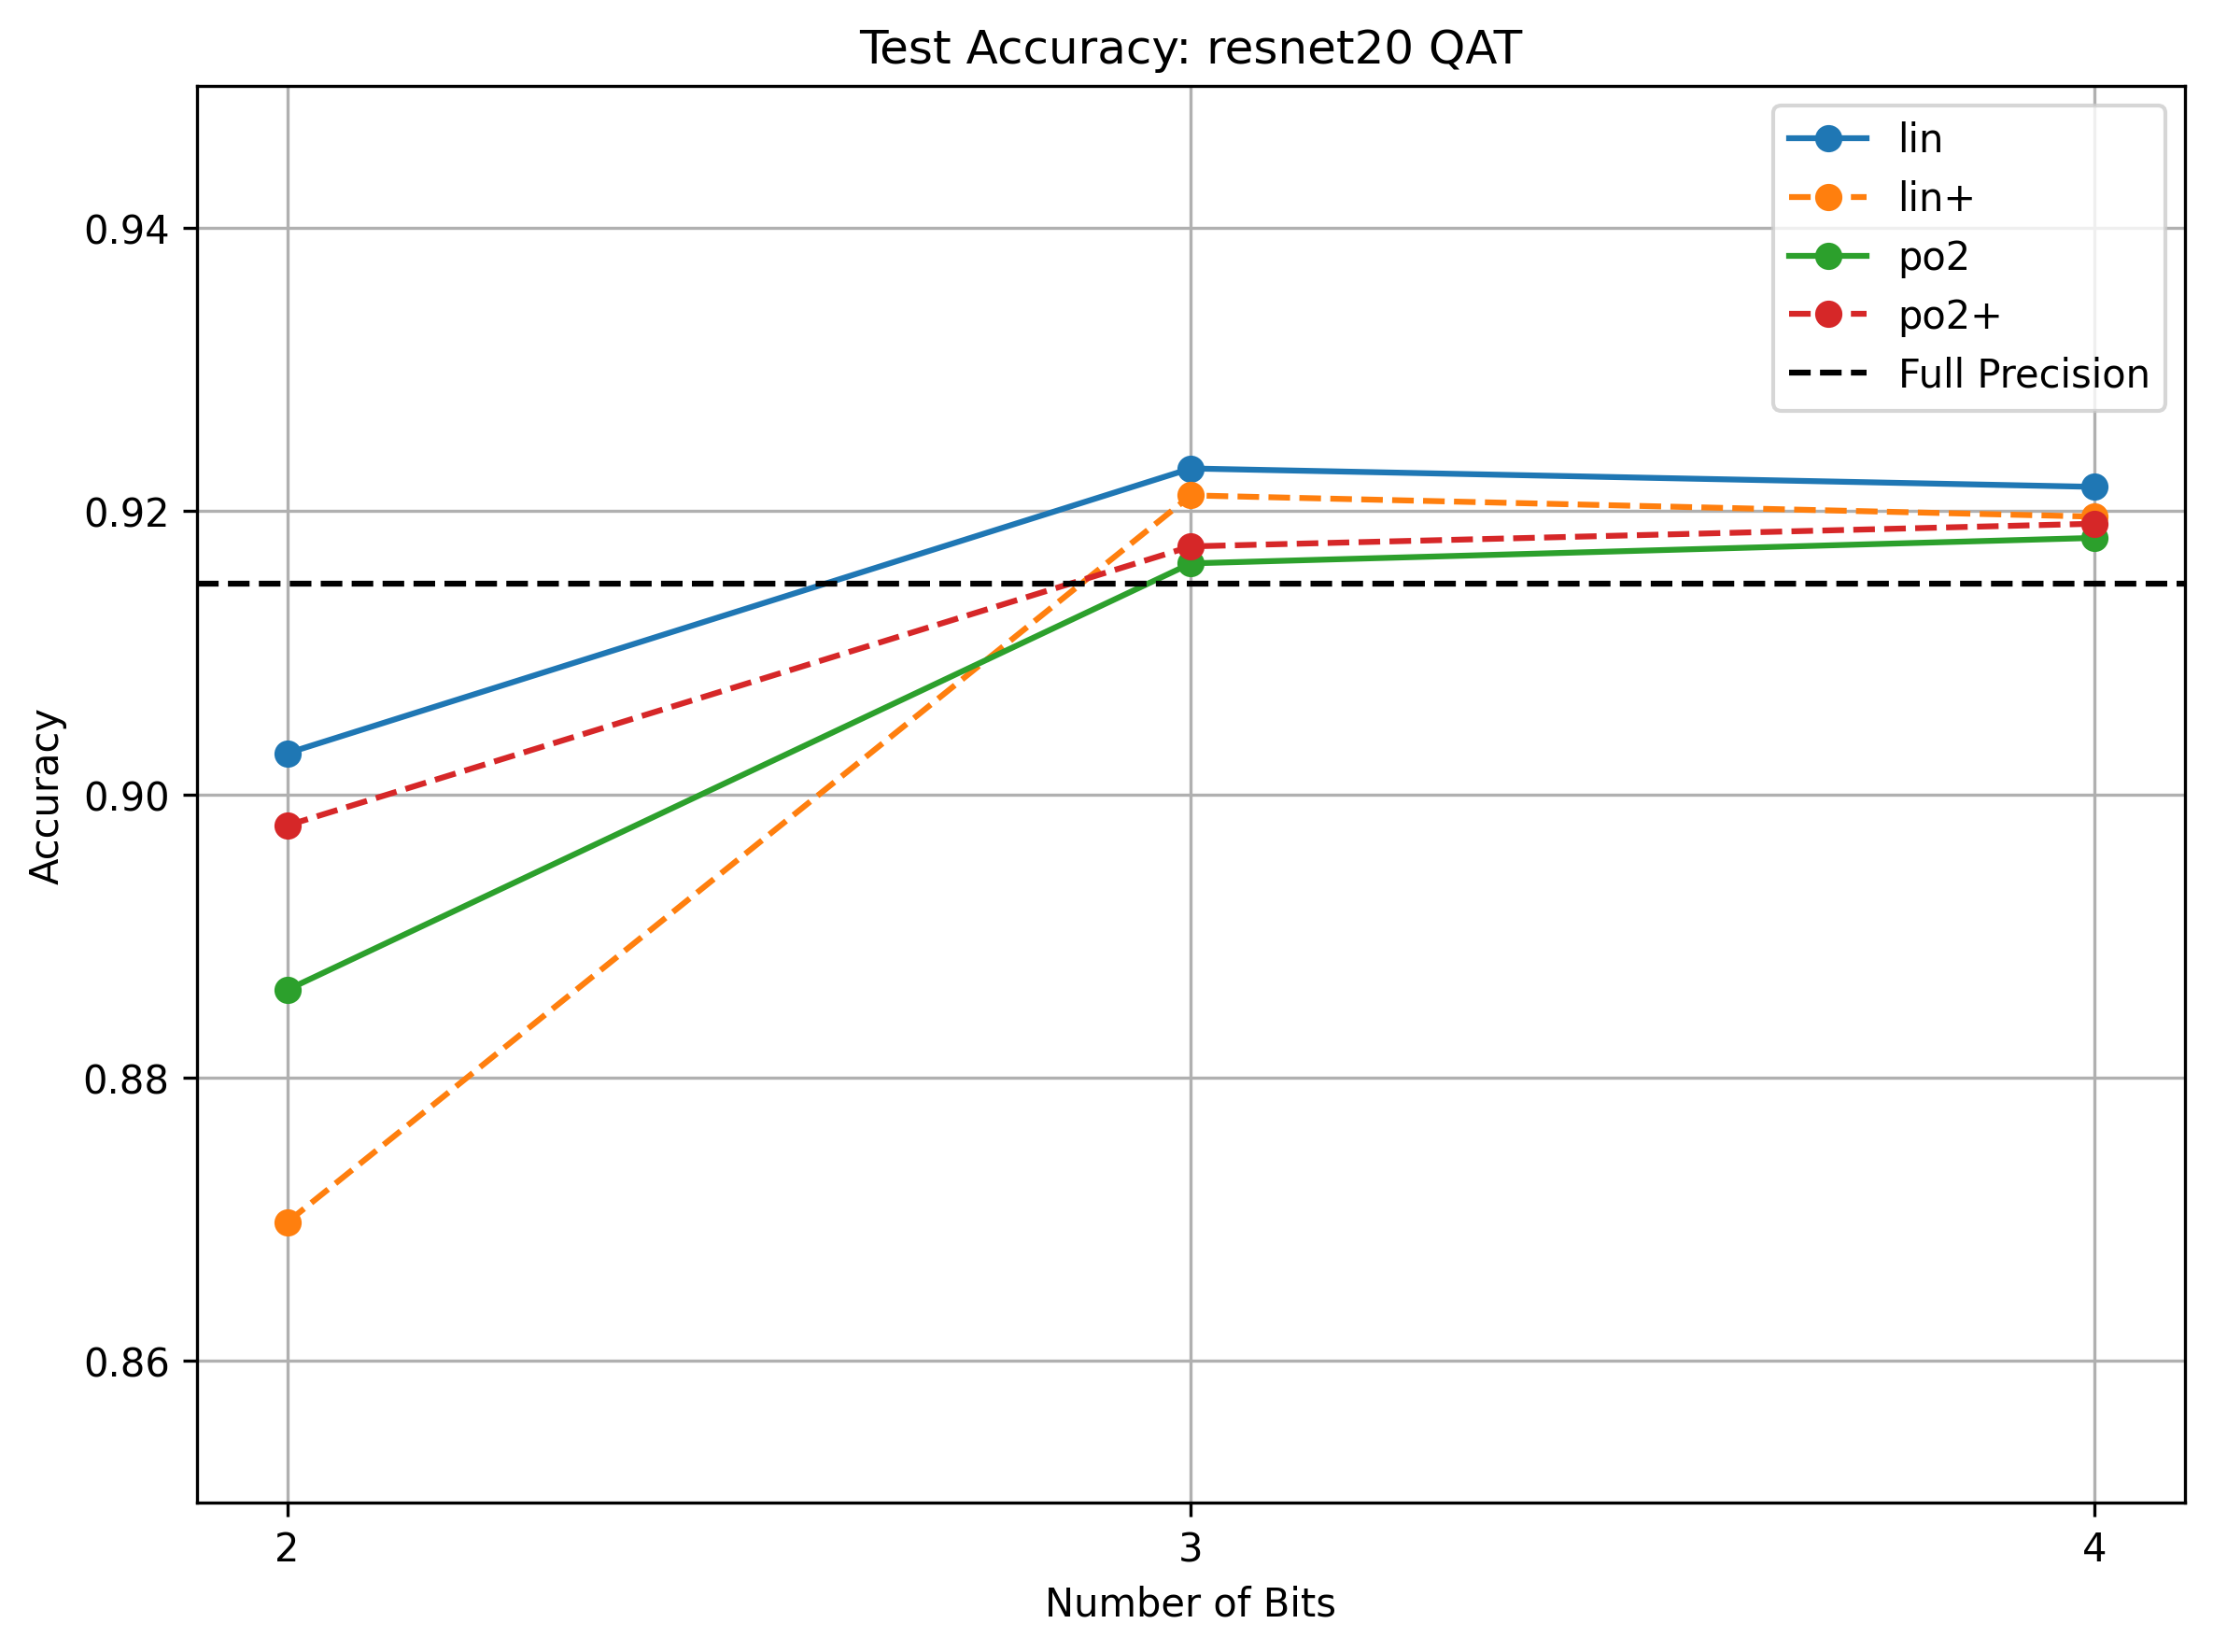

quantizer     lin    lin+  lin+ (%)     po2    po2+  po2+ (%)
type bits                                                    
ptq  2     0.1062  0.1020     -3.95  0.0952  0.0950     -0.21
     3     0.7836  0.7360     -6.07  0.7531  0.7740      2.78
     4     0.8952  0.8820     -1.47  0.8636  0.8750      1.32
qat  2     0.9029  0.8698     -3.67  0.8862  0.8978      1.31
     3     0.9230  0.9211     -0.21  0.9163  0.9175      0.13
     4     0.9217  0.9196     -0.23  0.9181  0.9191      0.11

In [195]:
df1 = get_results("resnet20", 0.85, 0.95, qat=True)
df1

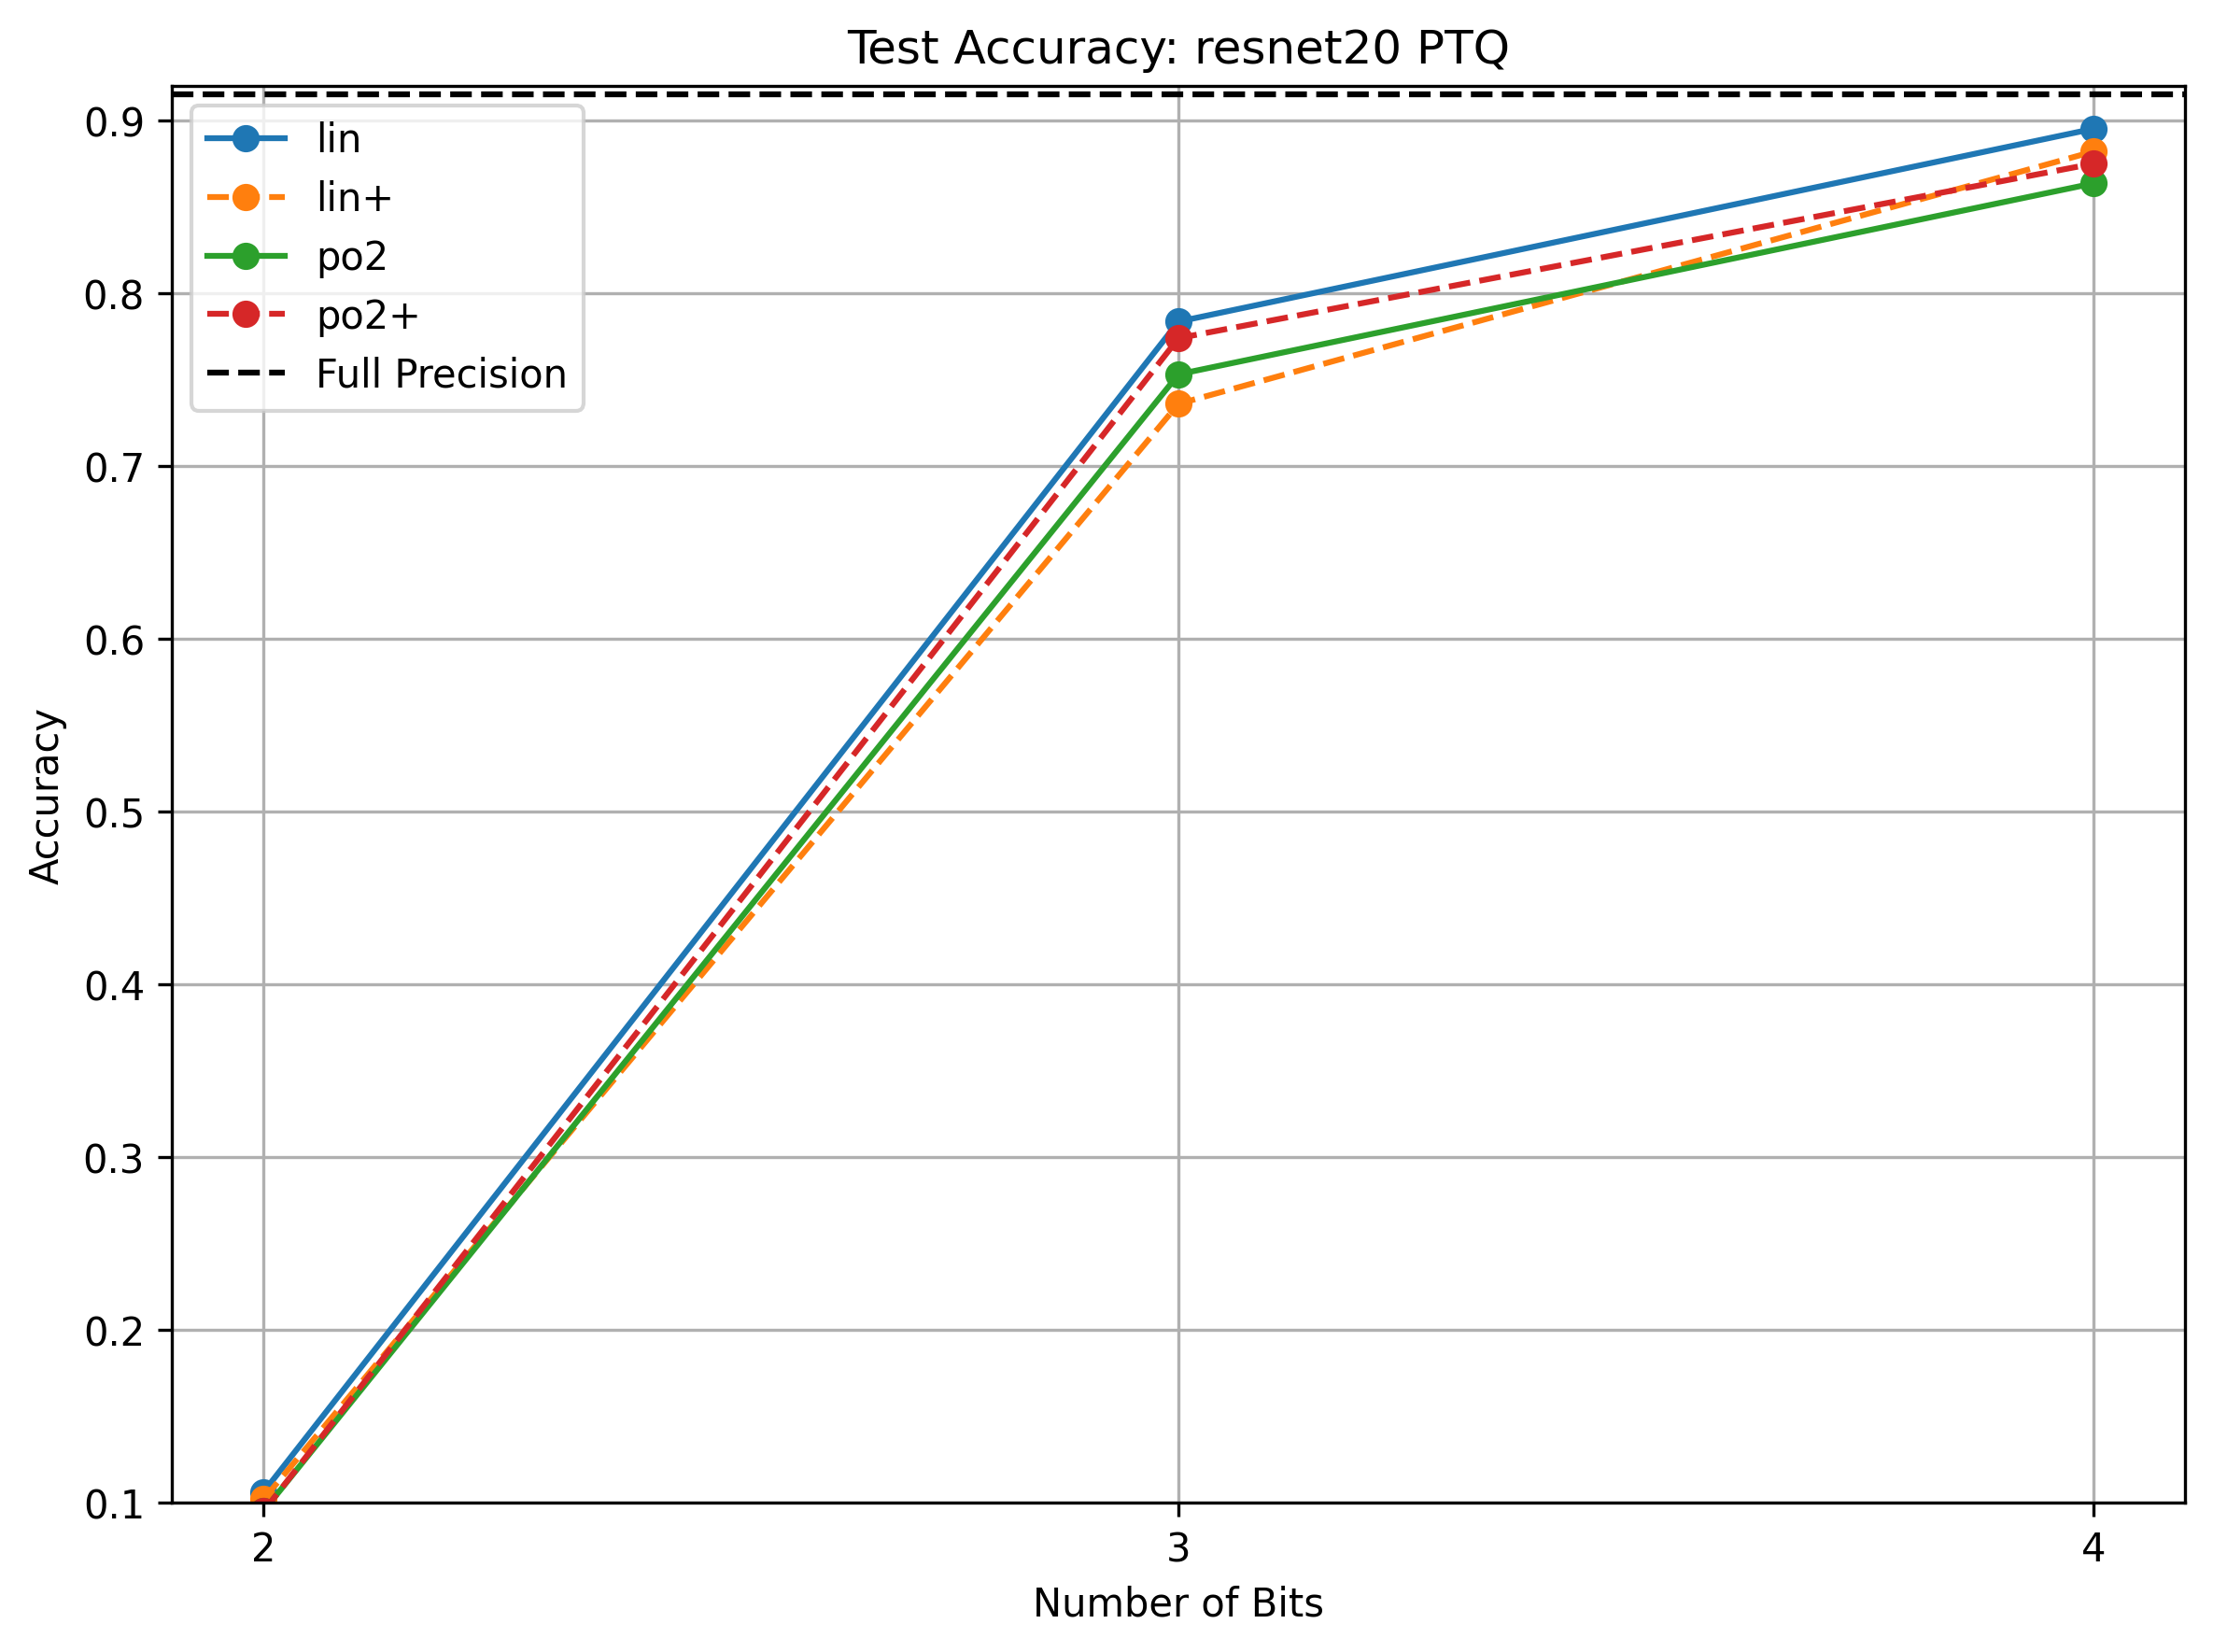

In [196]:
_ = get_results("resnet20", 0.1, 0.92, qat=False)

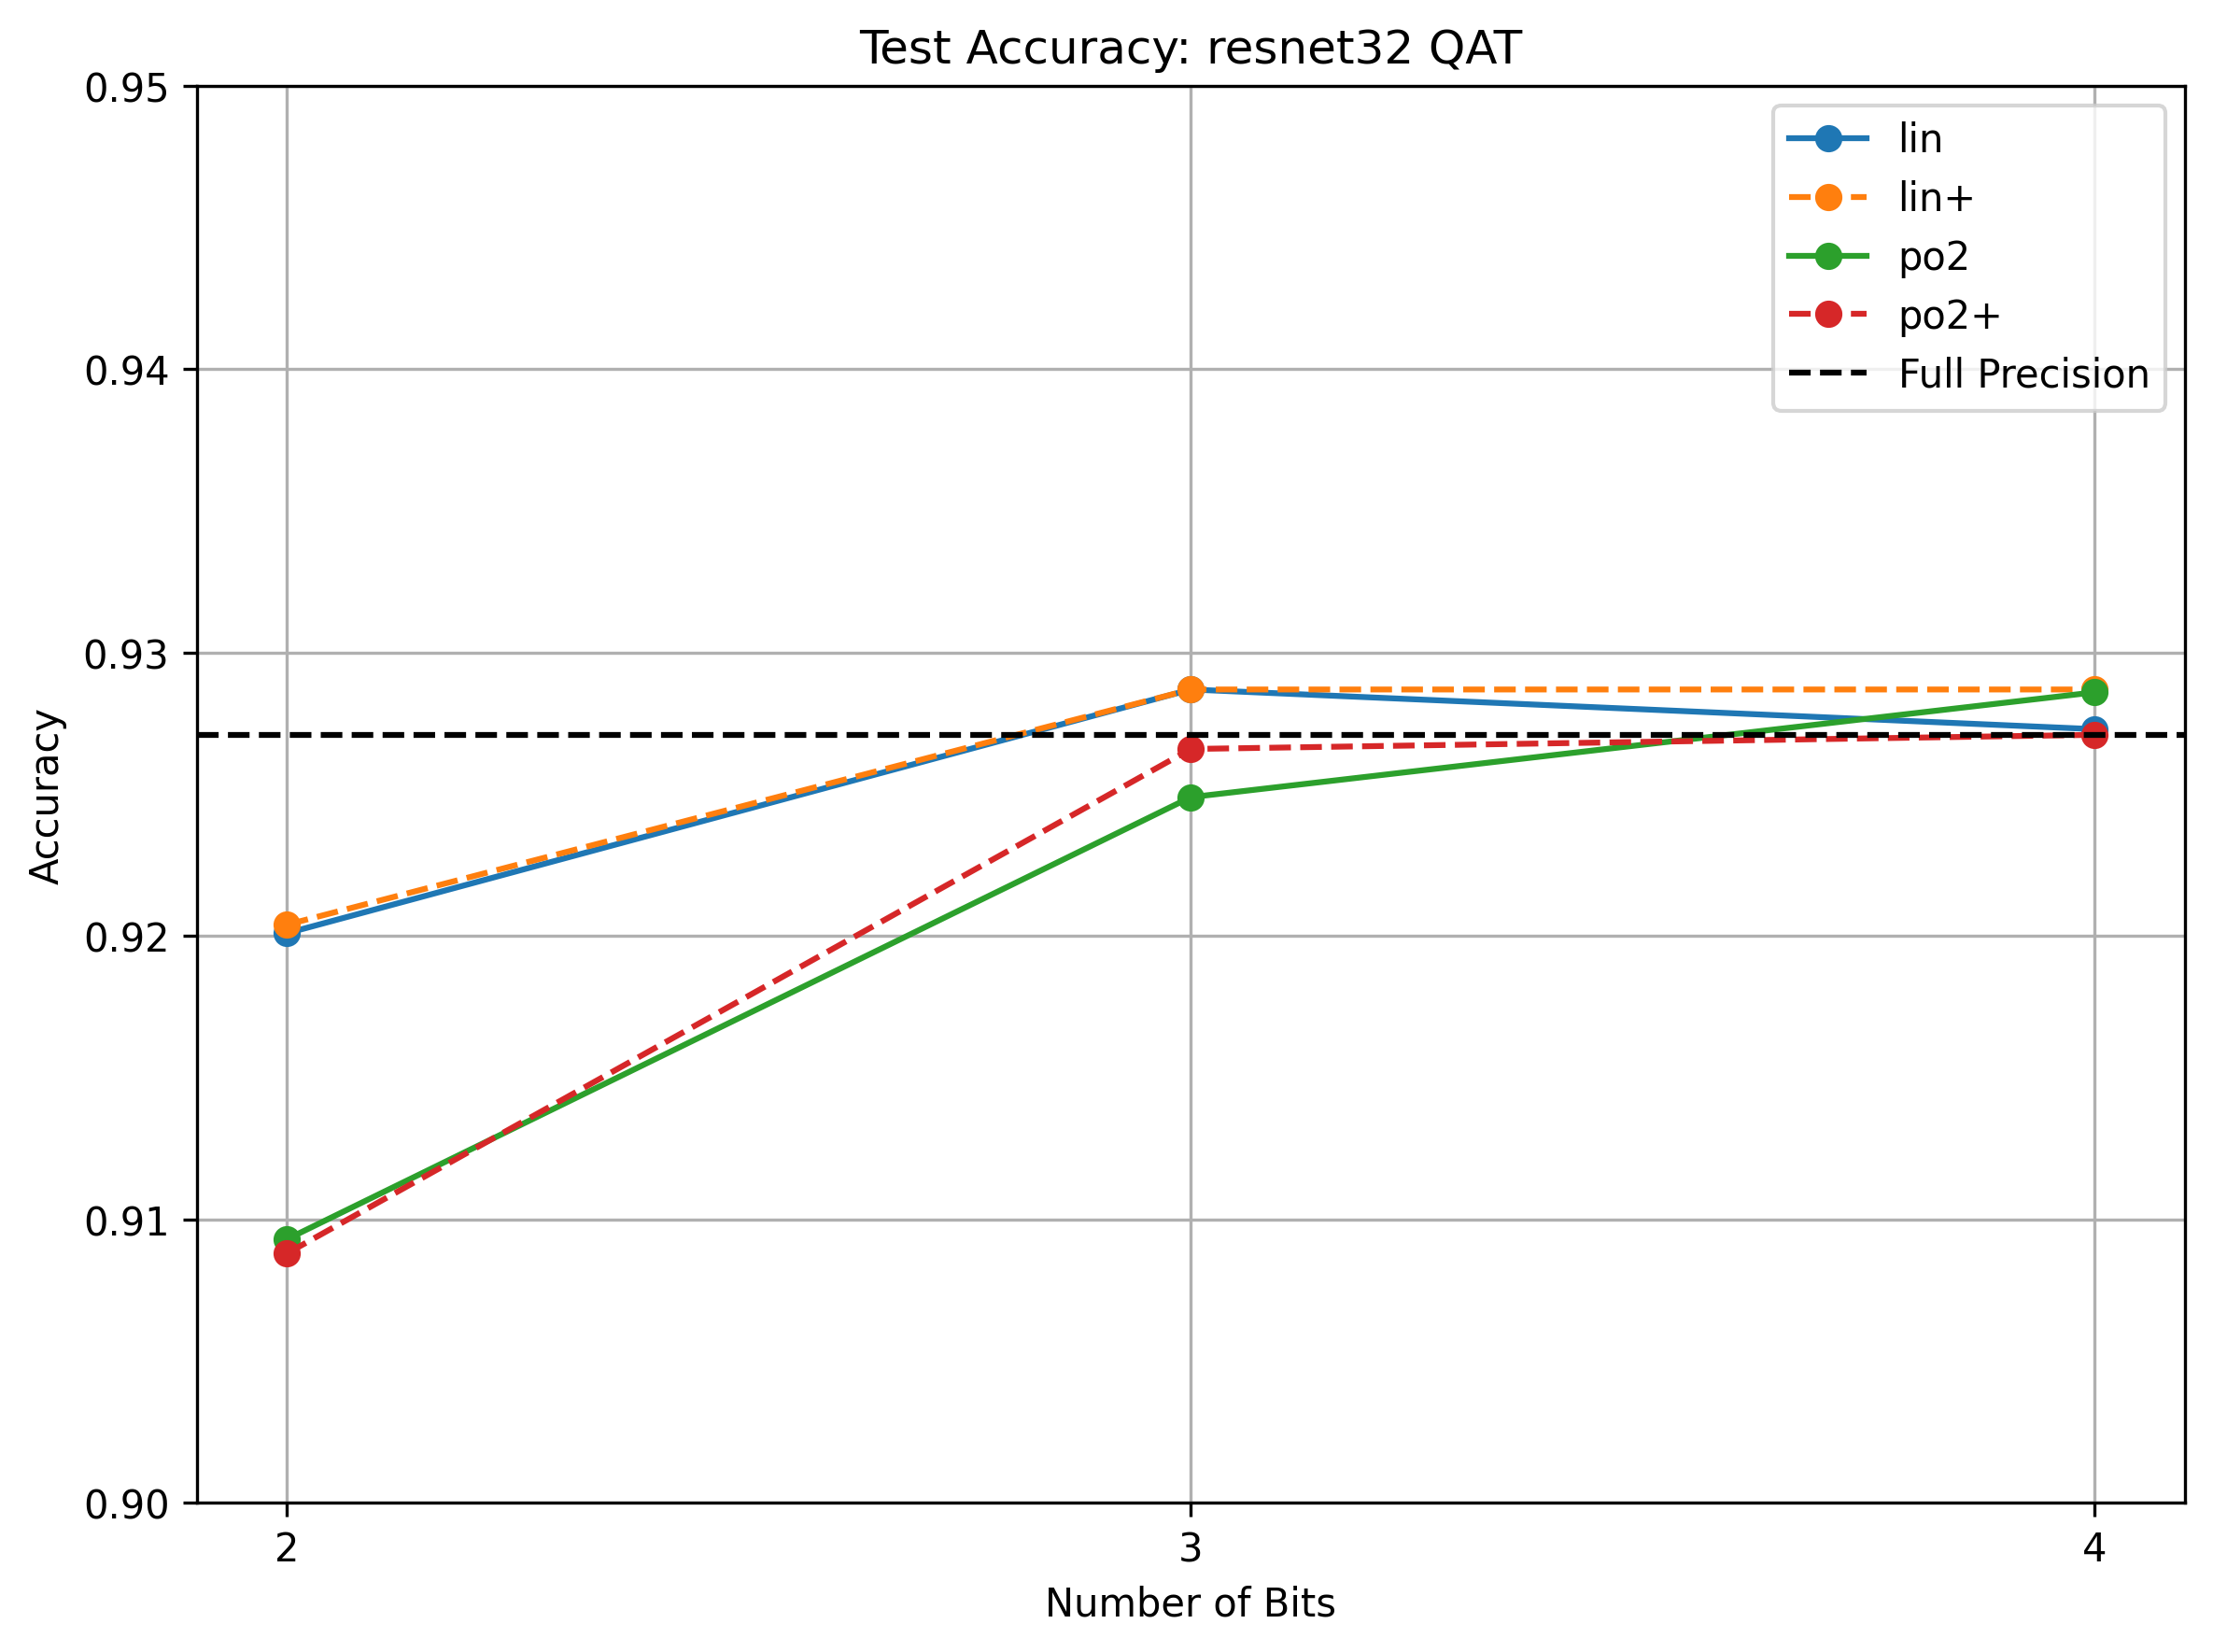

In [197]:
df2 = get_results("resnet32", 0.9, 0.95, qat=True)

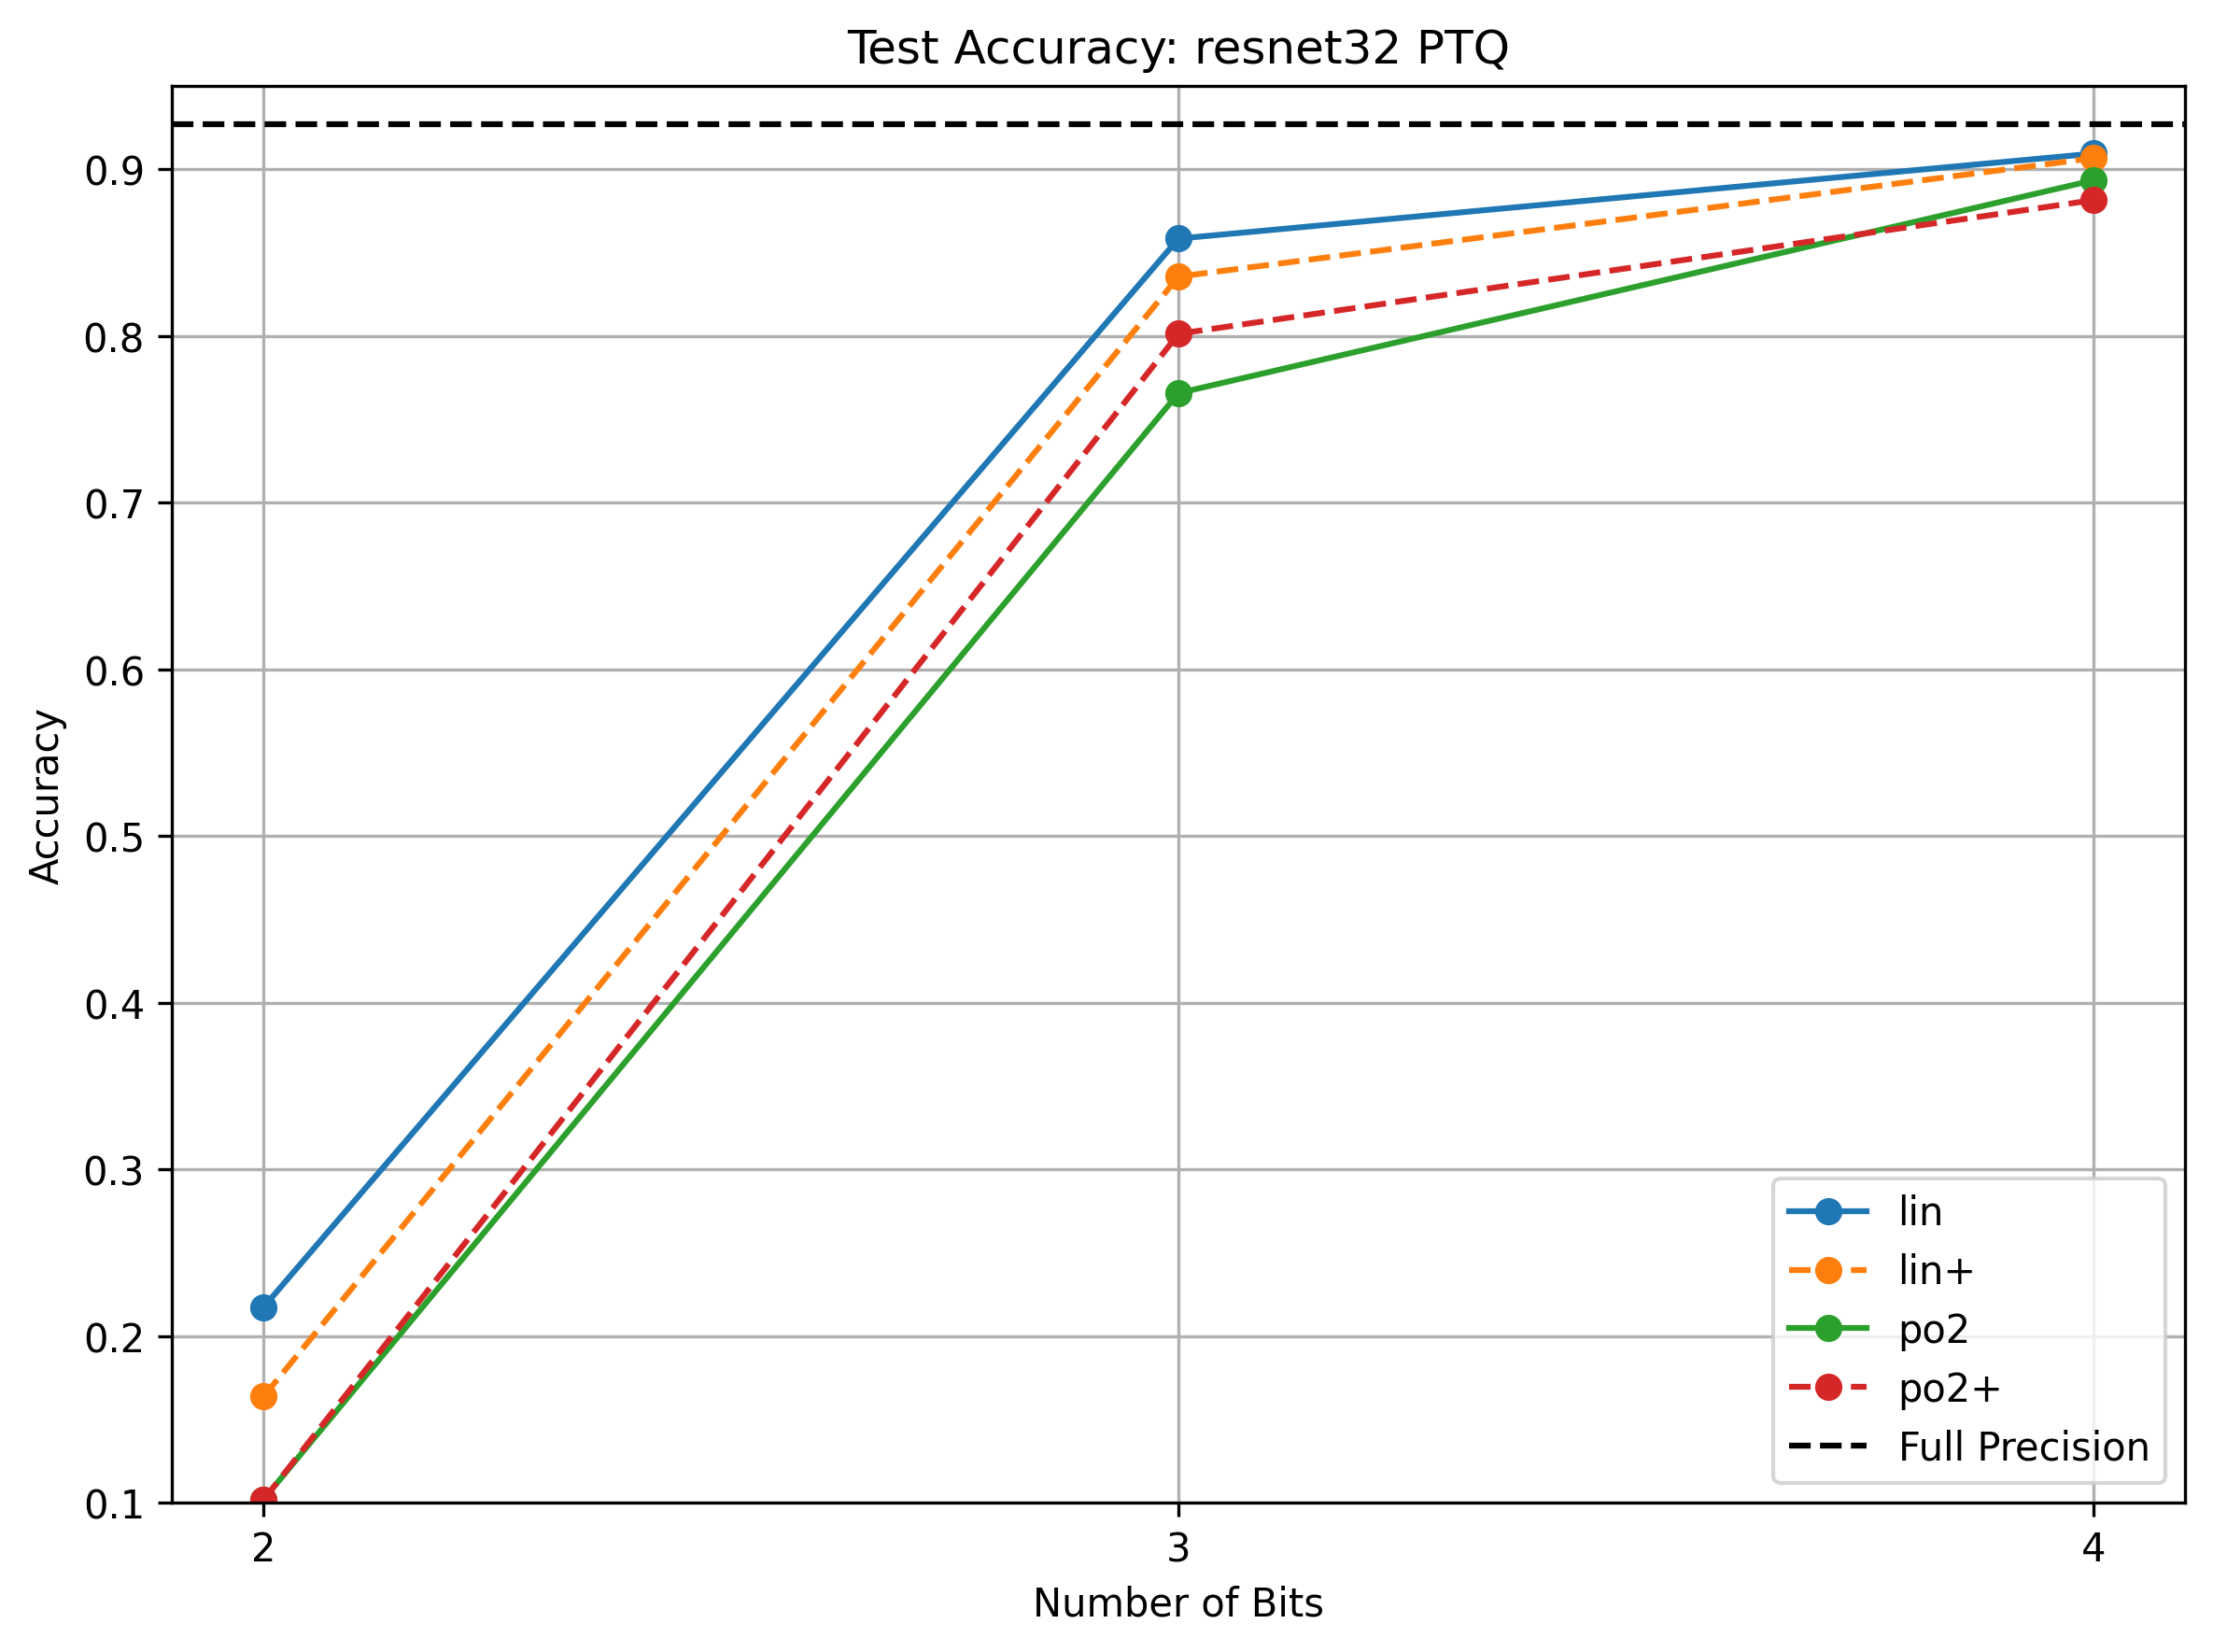

In [198]:
_ = get_results("resnet32", 0.1, 0.95, qat=False)

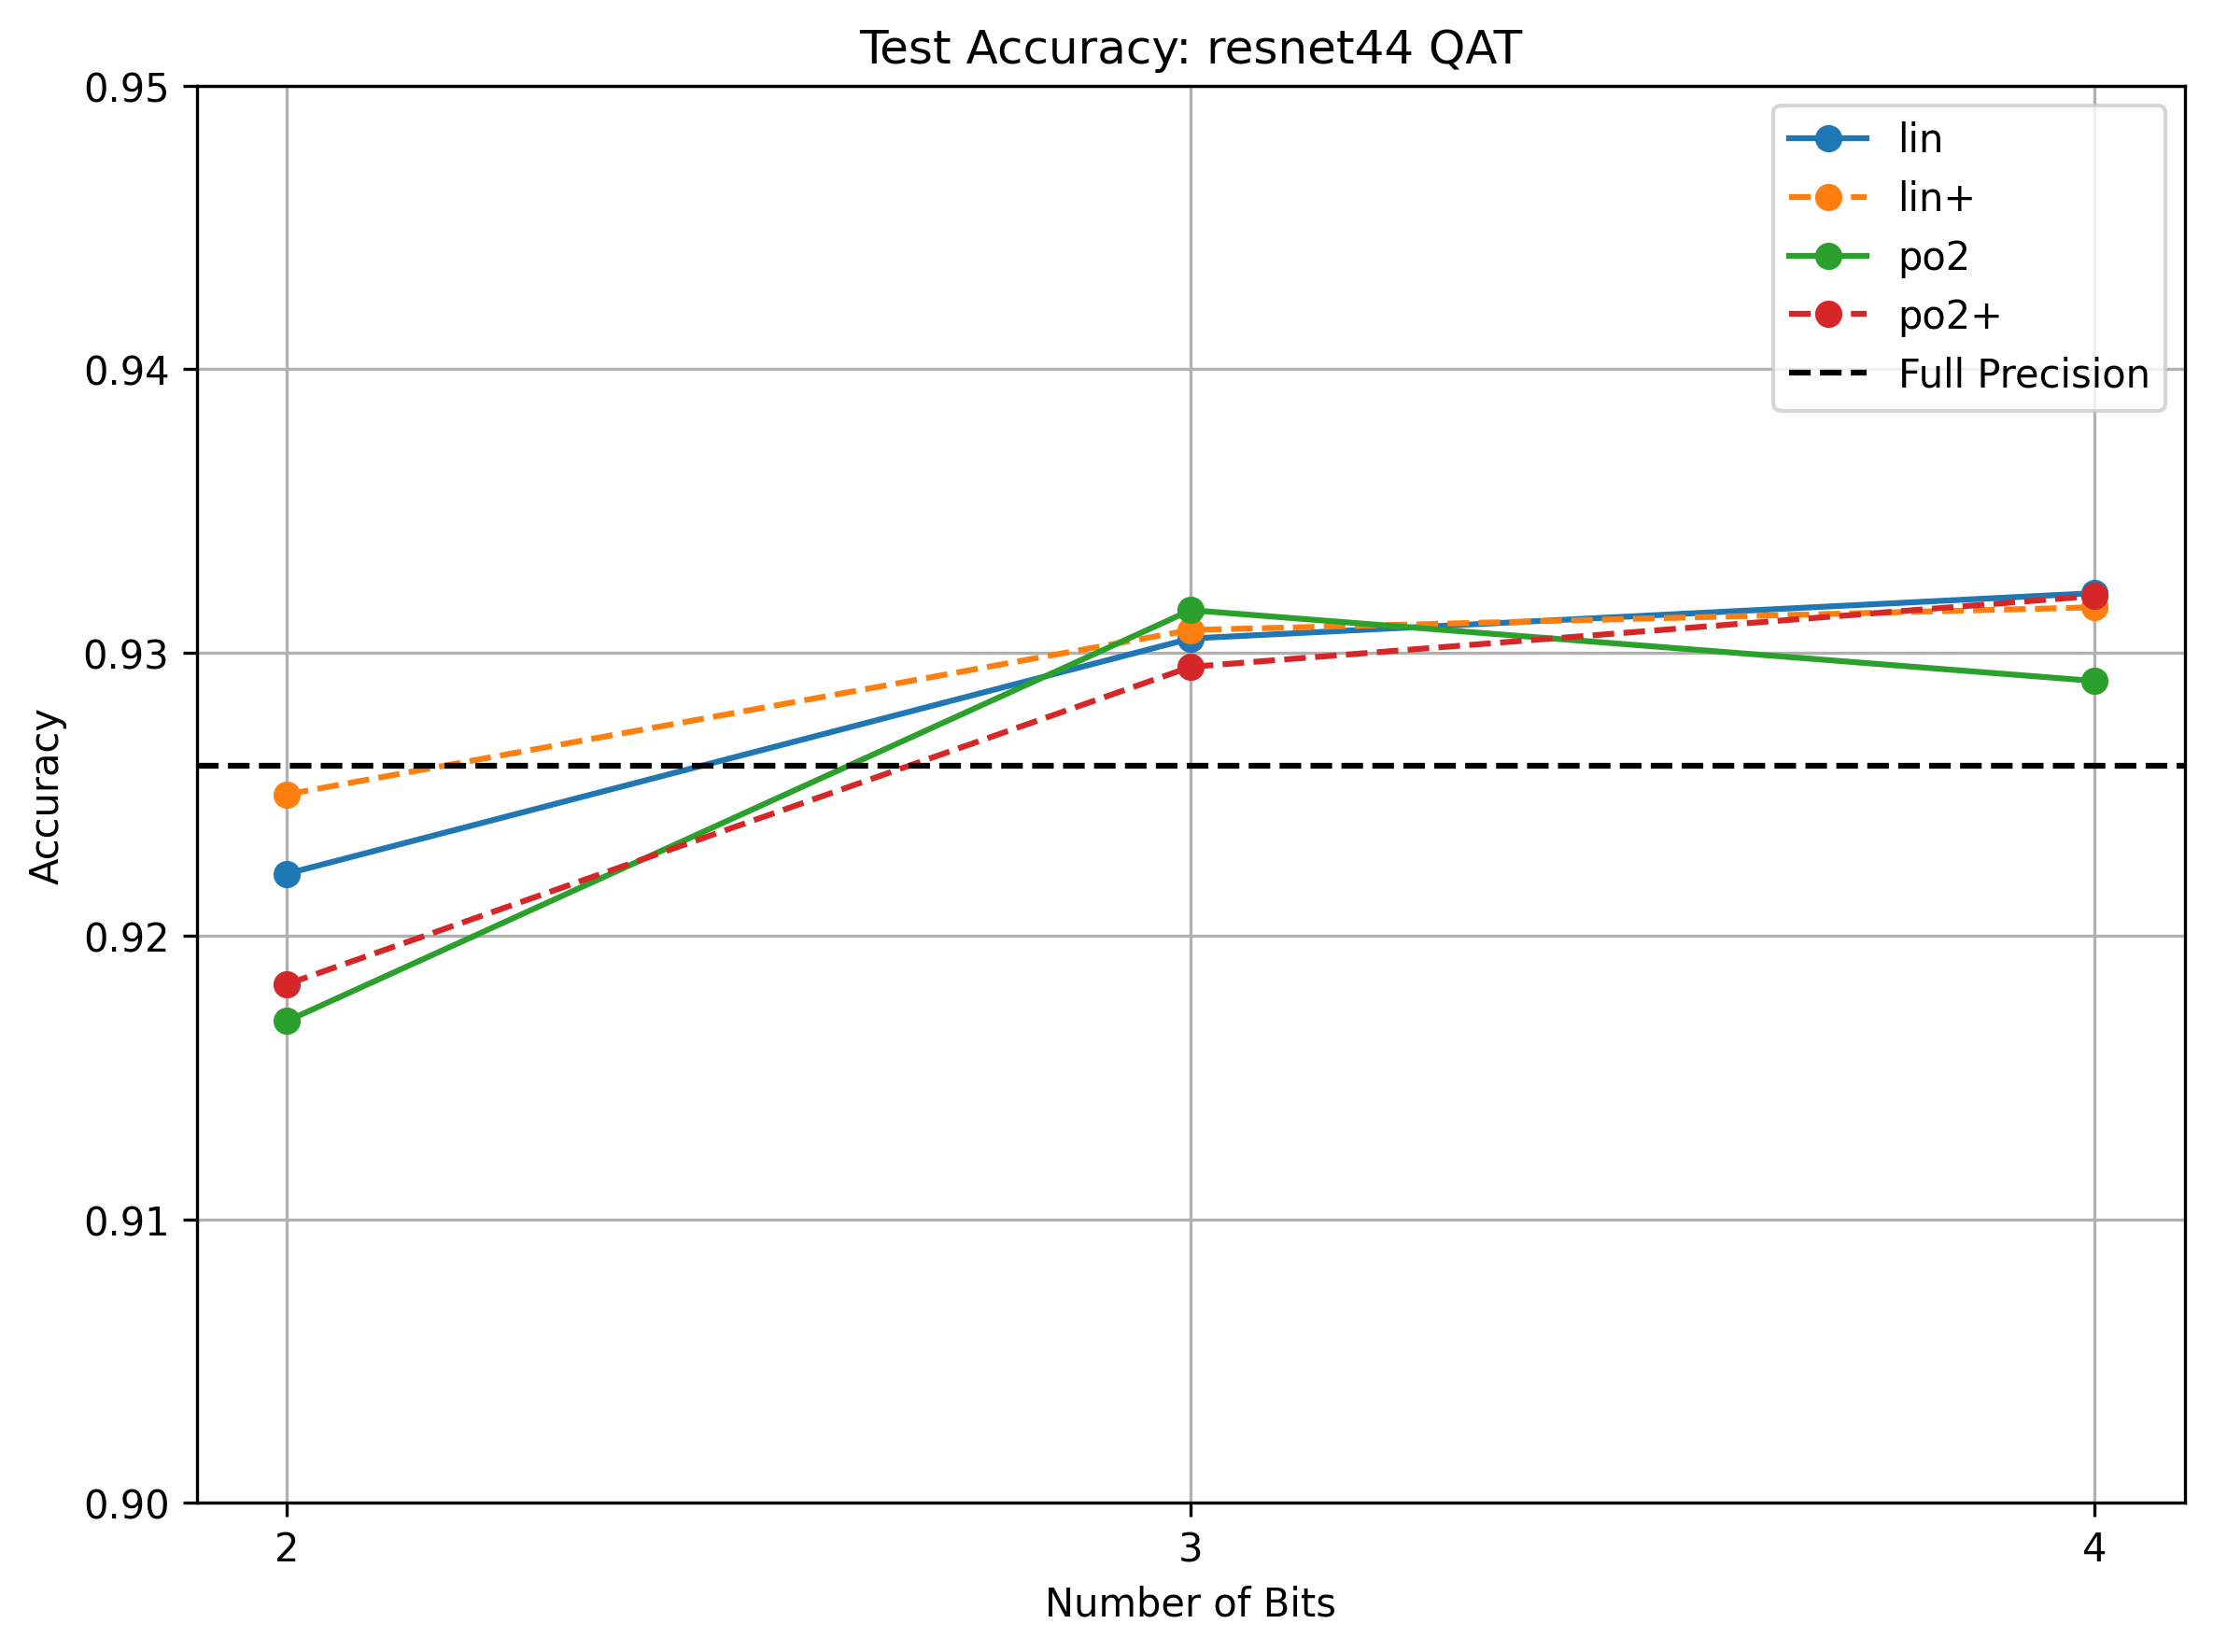

In [199]:
df3 = get_results("resnet44", 0.9, 0.95, qat=True)

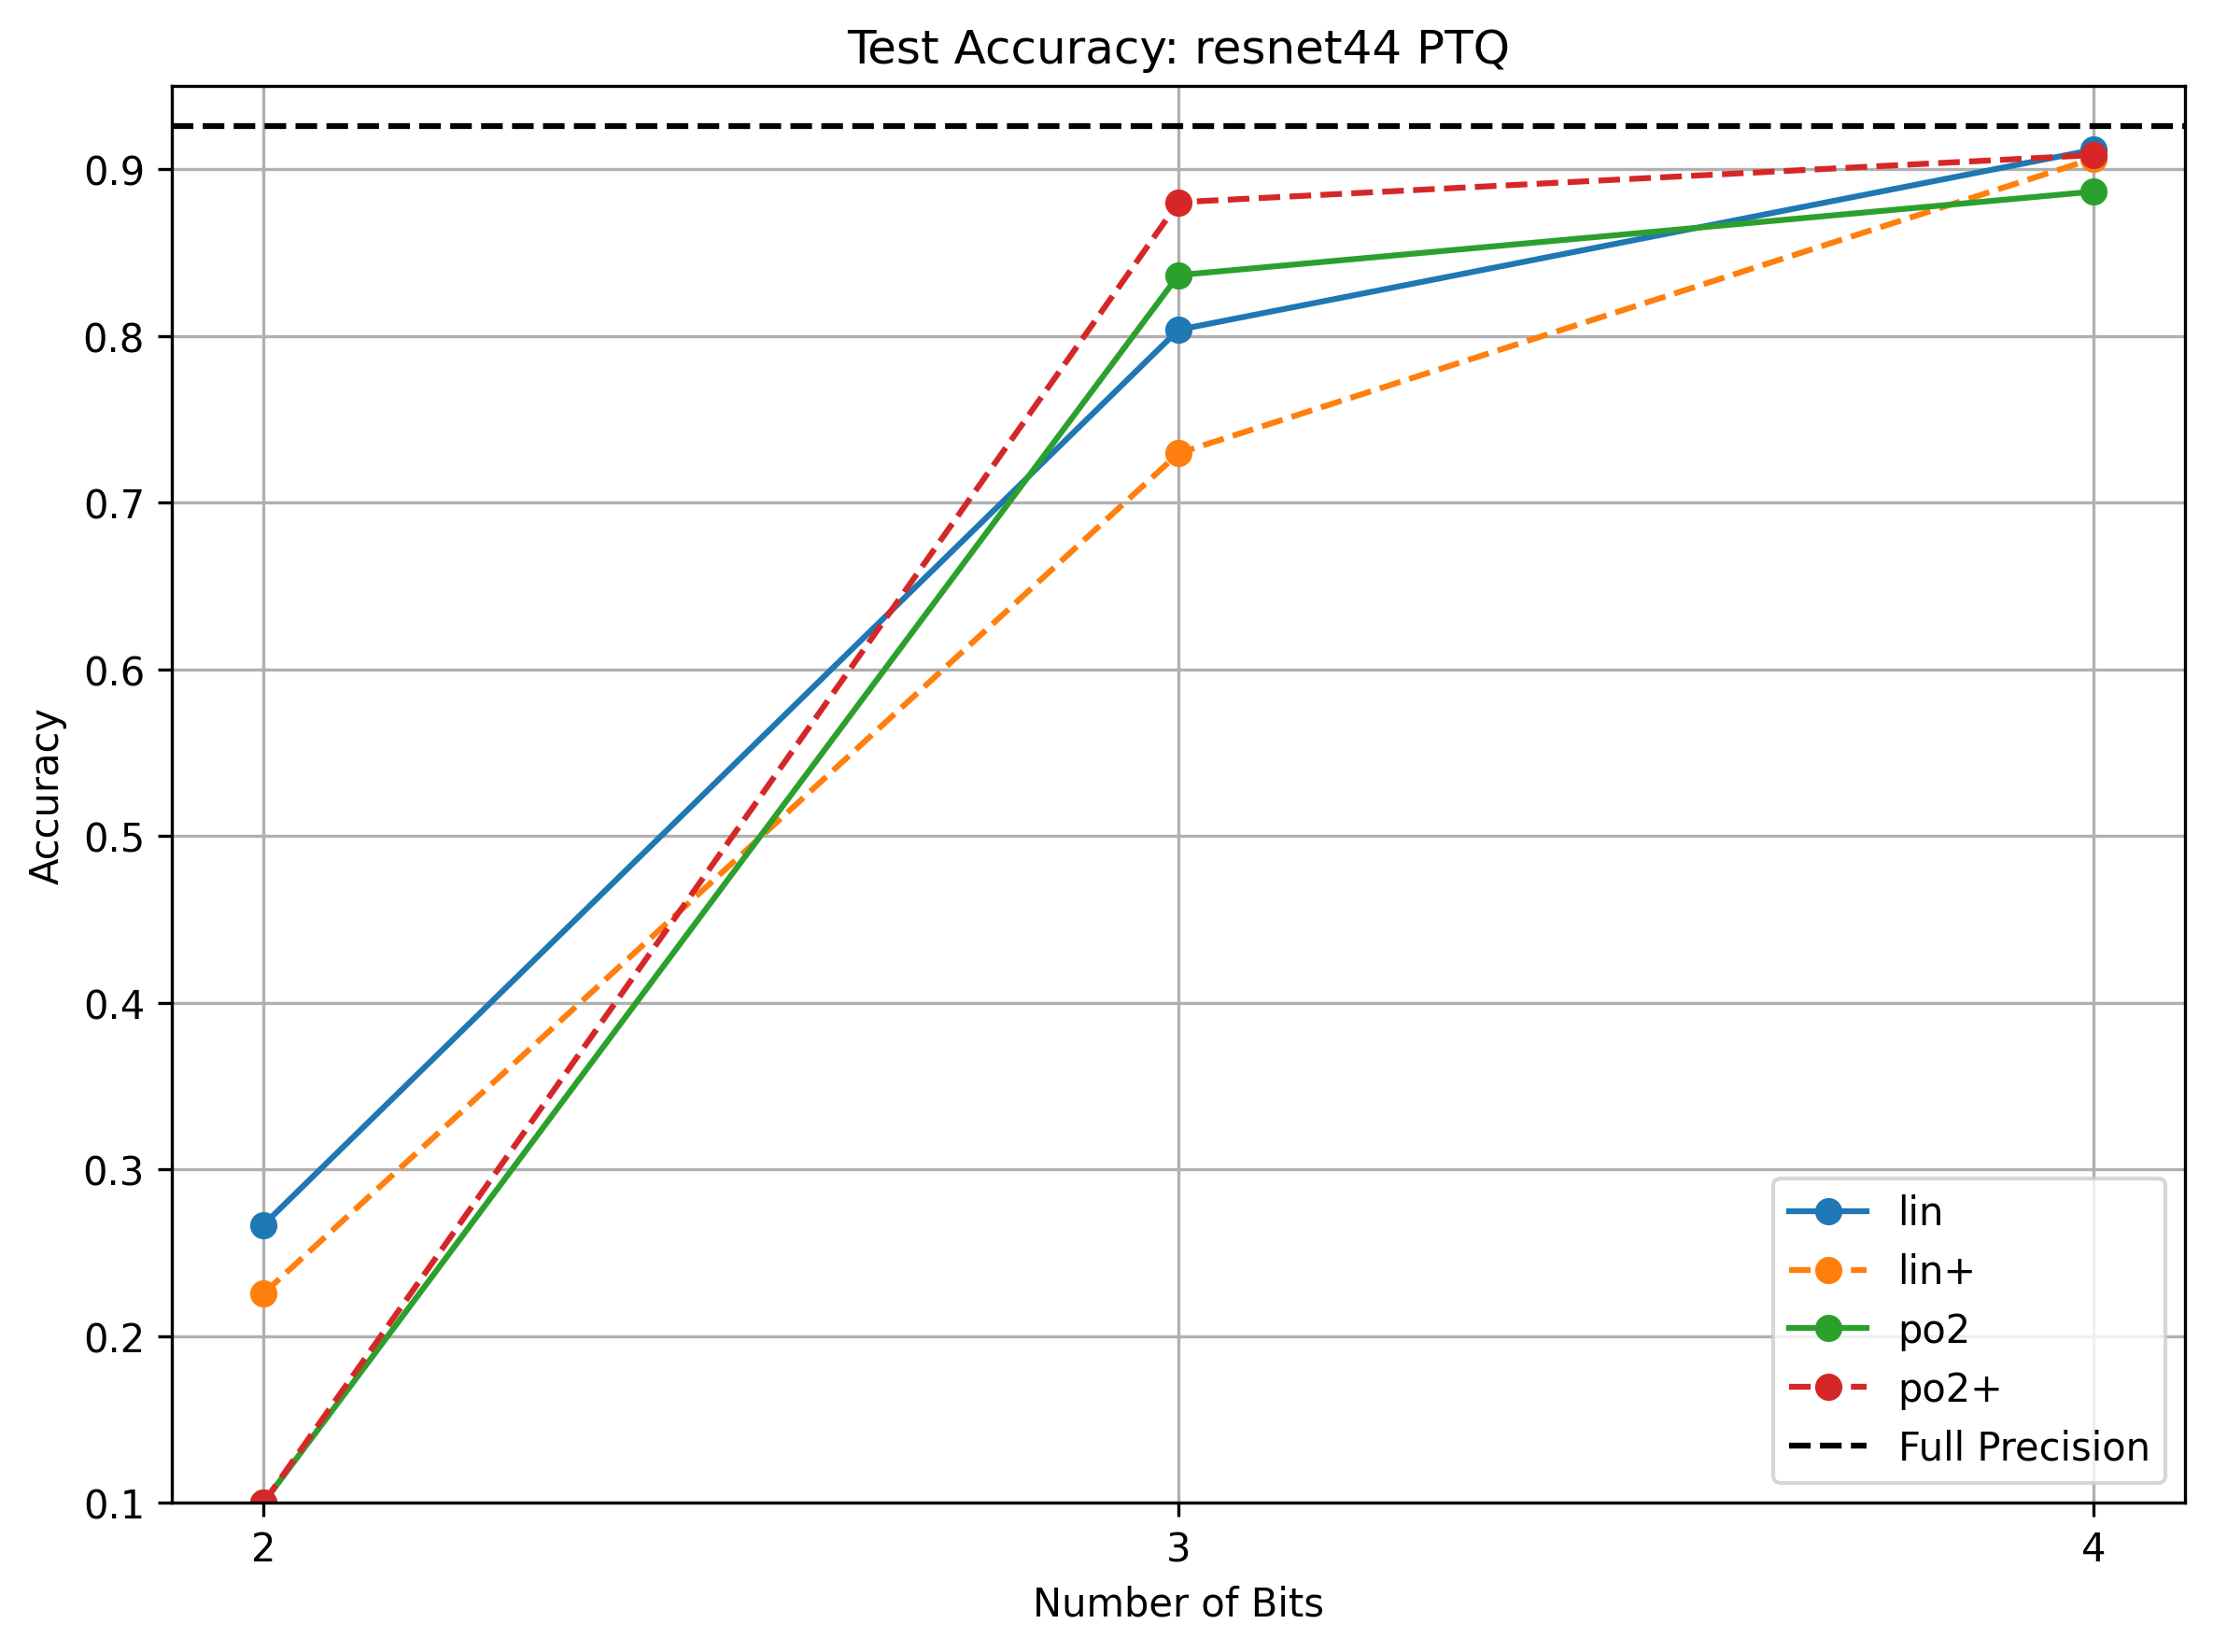

In [200]:
_ = get_results("resnet44", 0.1, 0.95, qat=False)

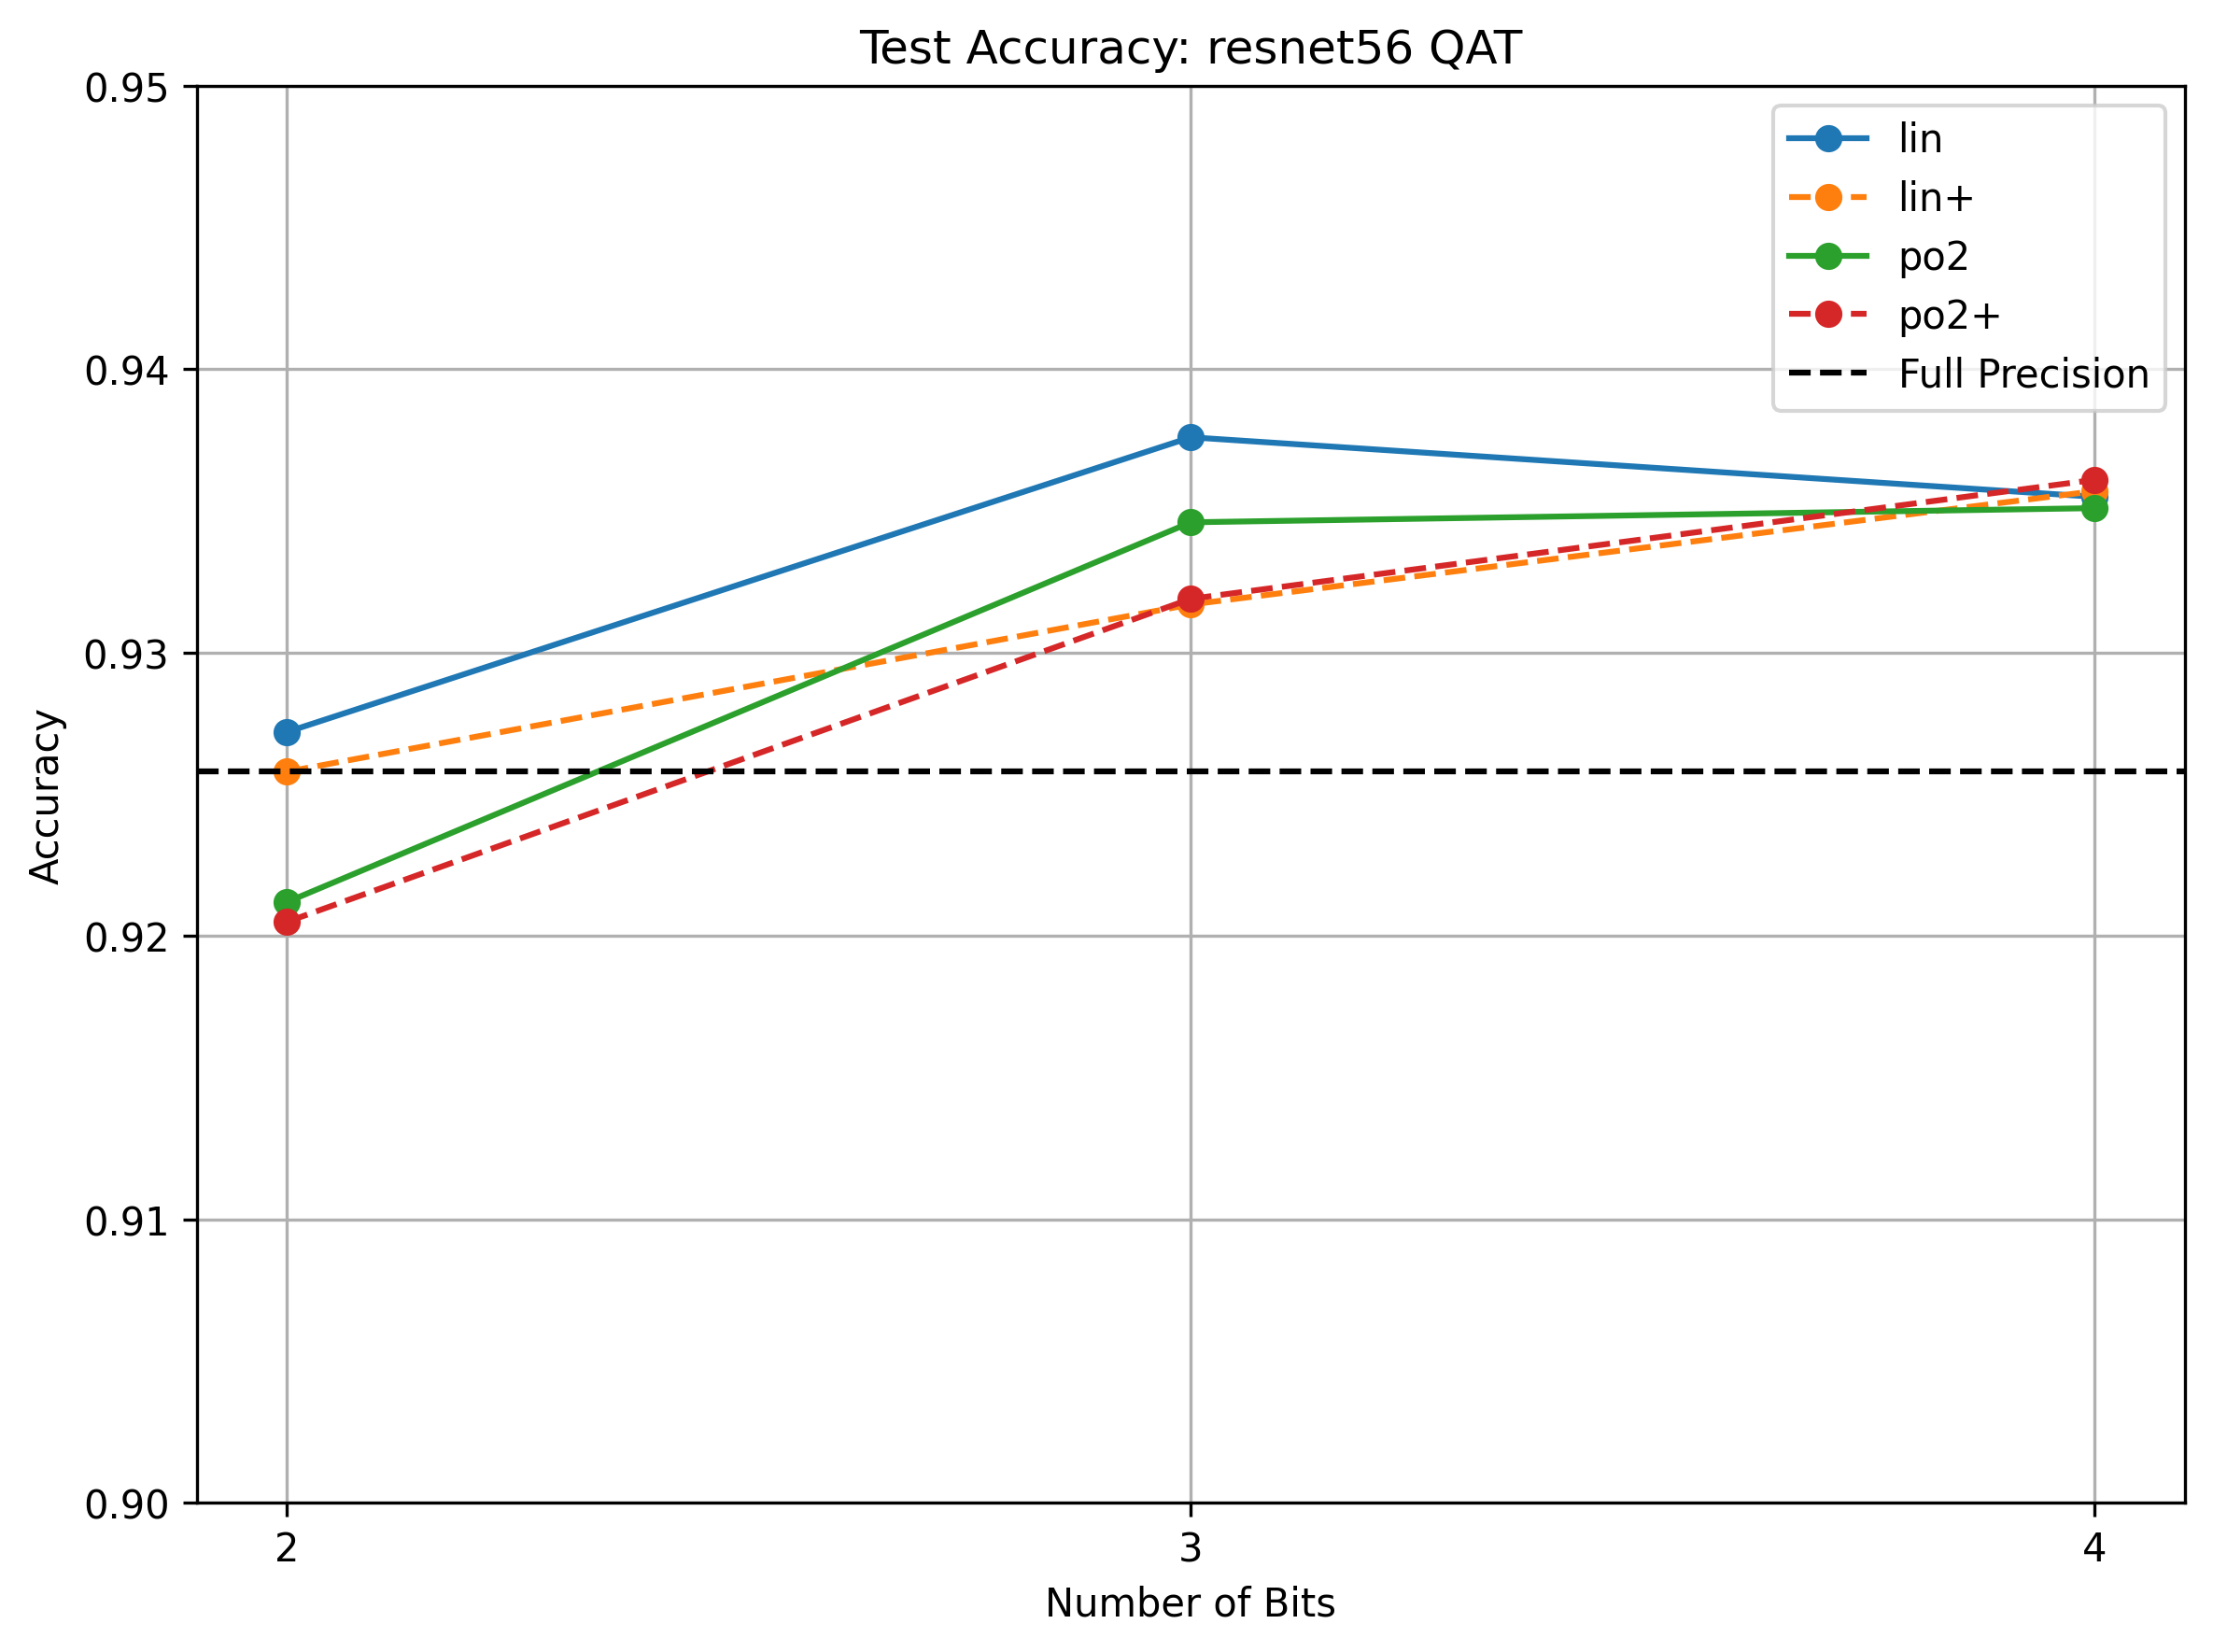

In [201]:
df4 = get_results("resnet56", 0.9, 0.95, qat=True)

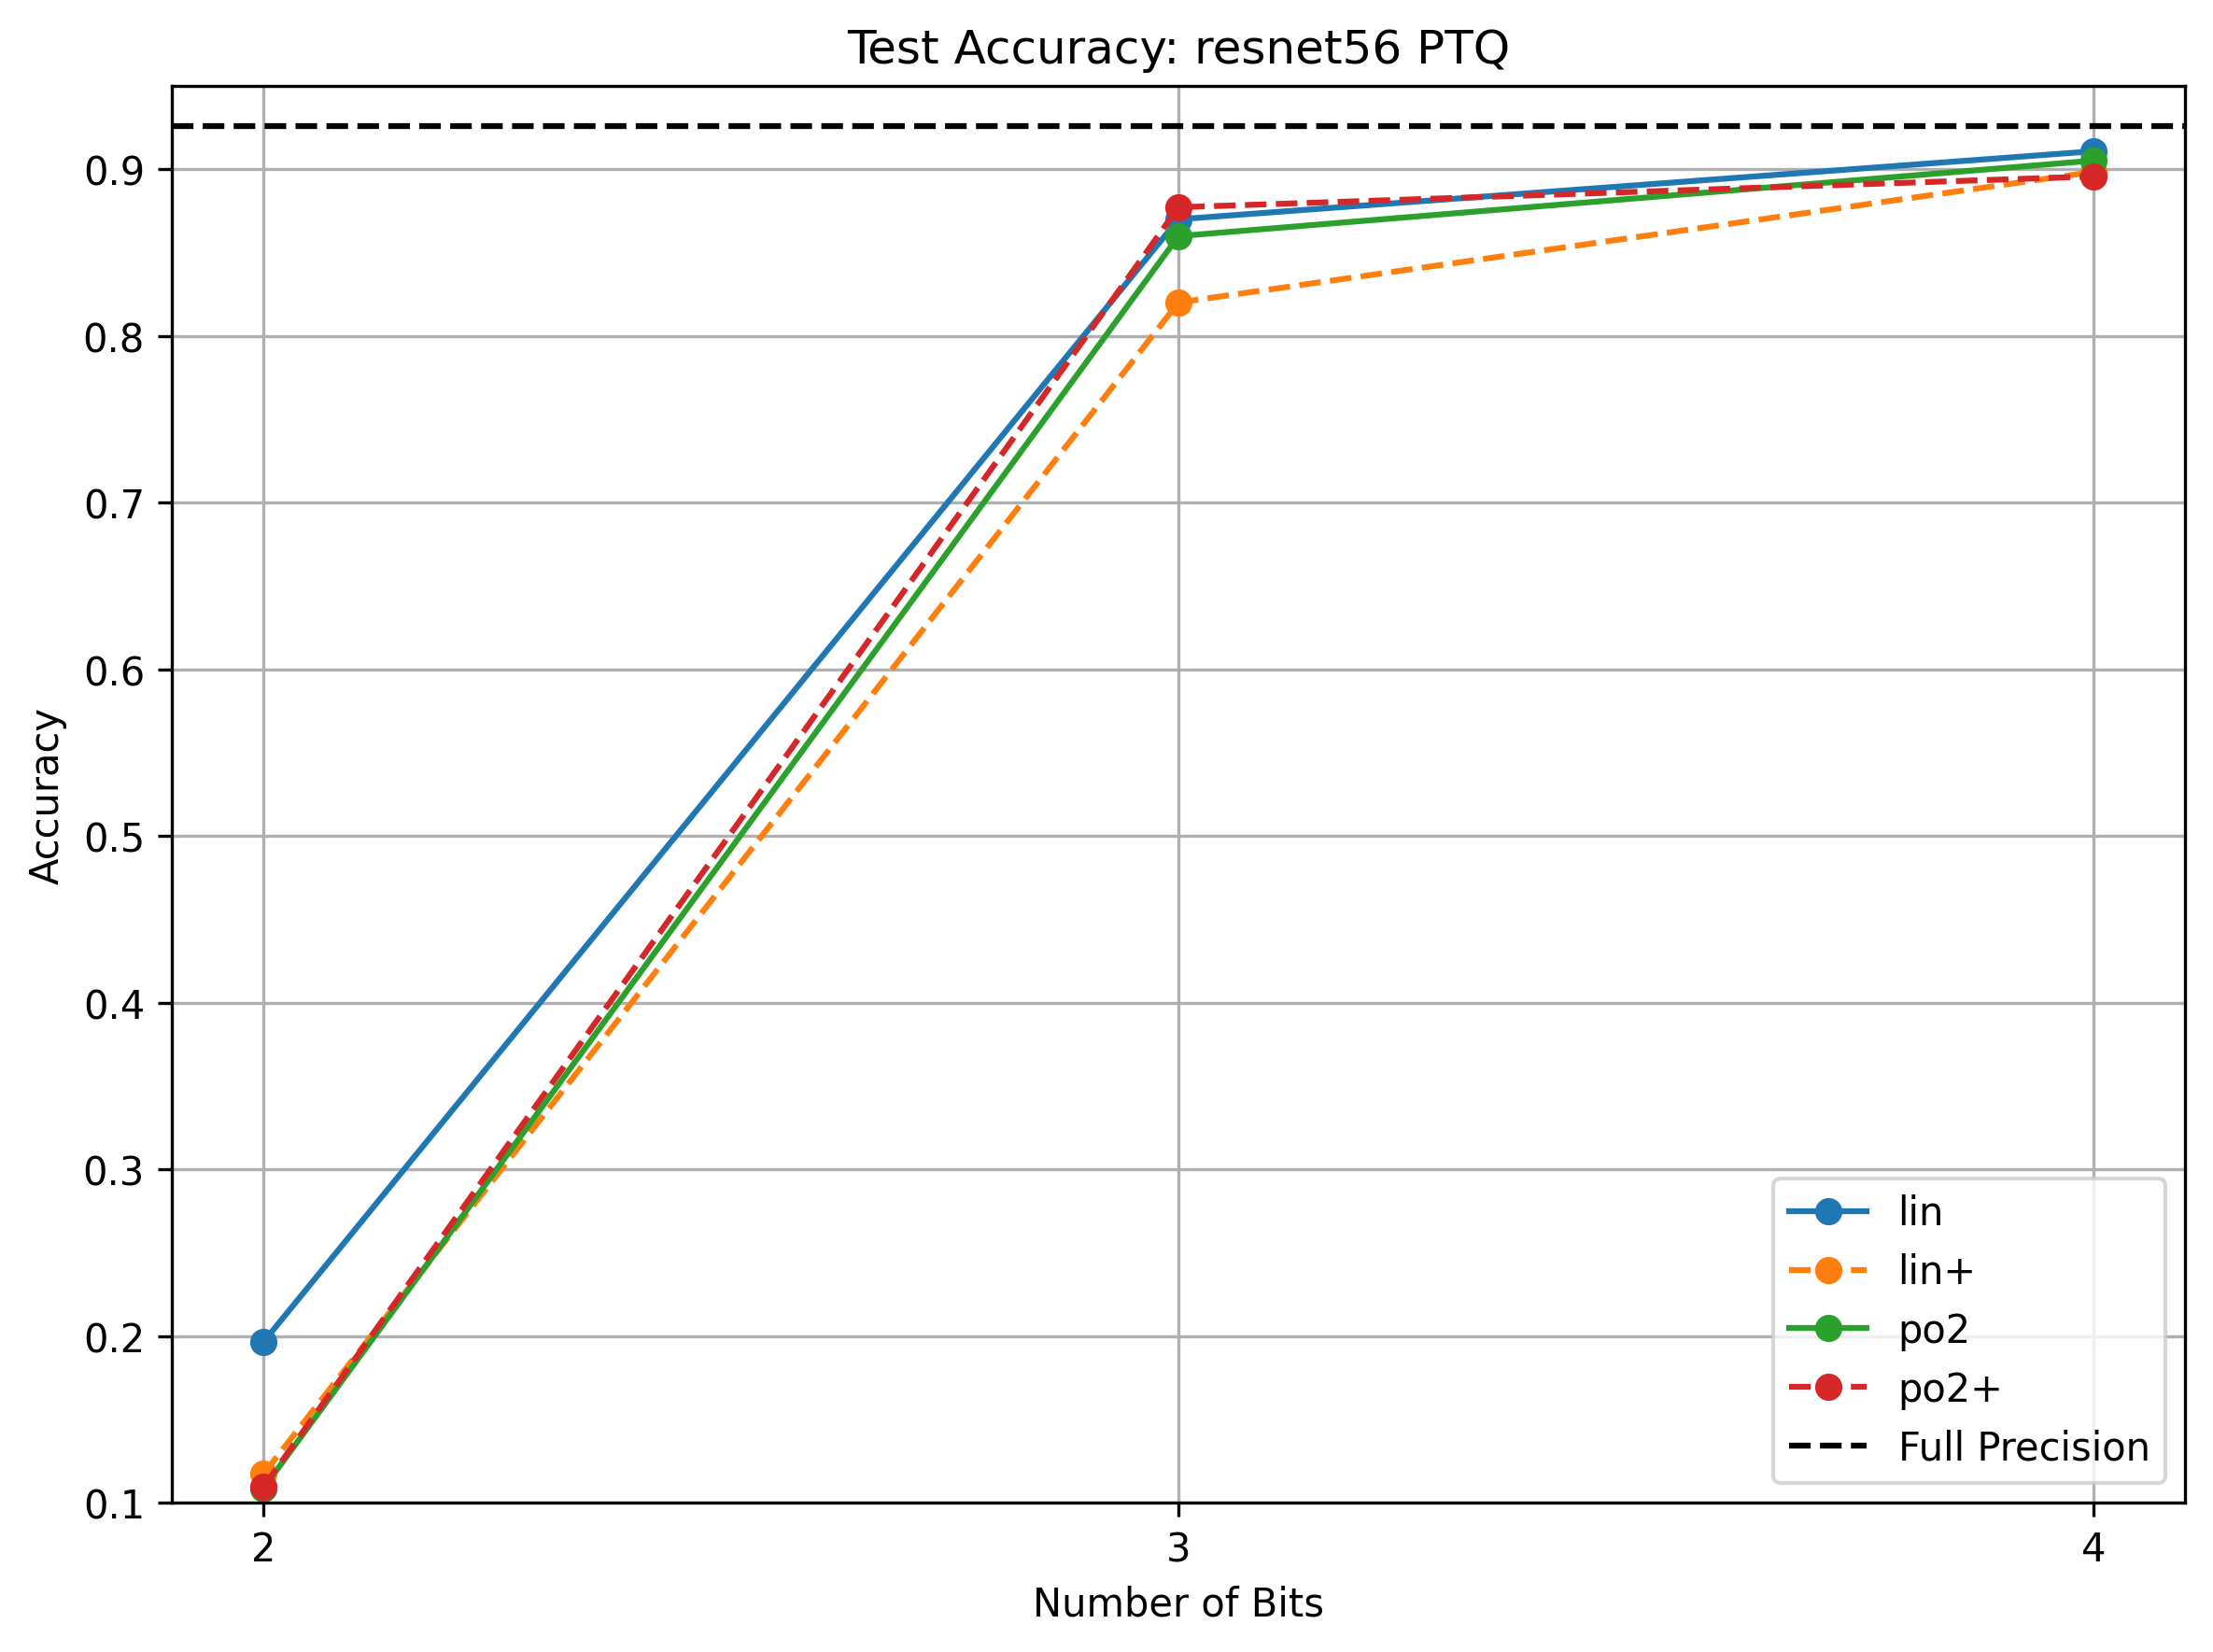

In [202]:
_ = get_results("resnet56", 0.1, 0.95, qat=False)

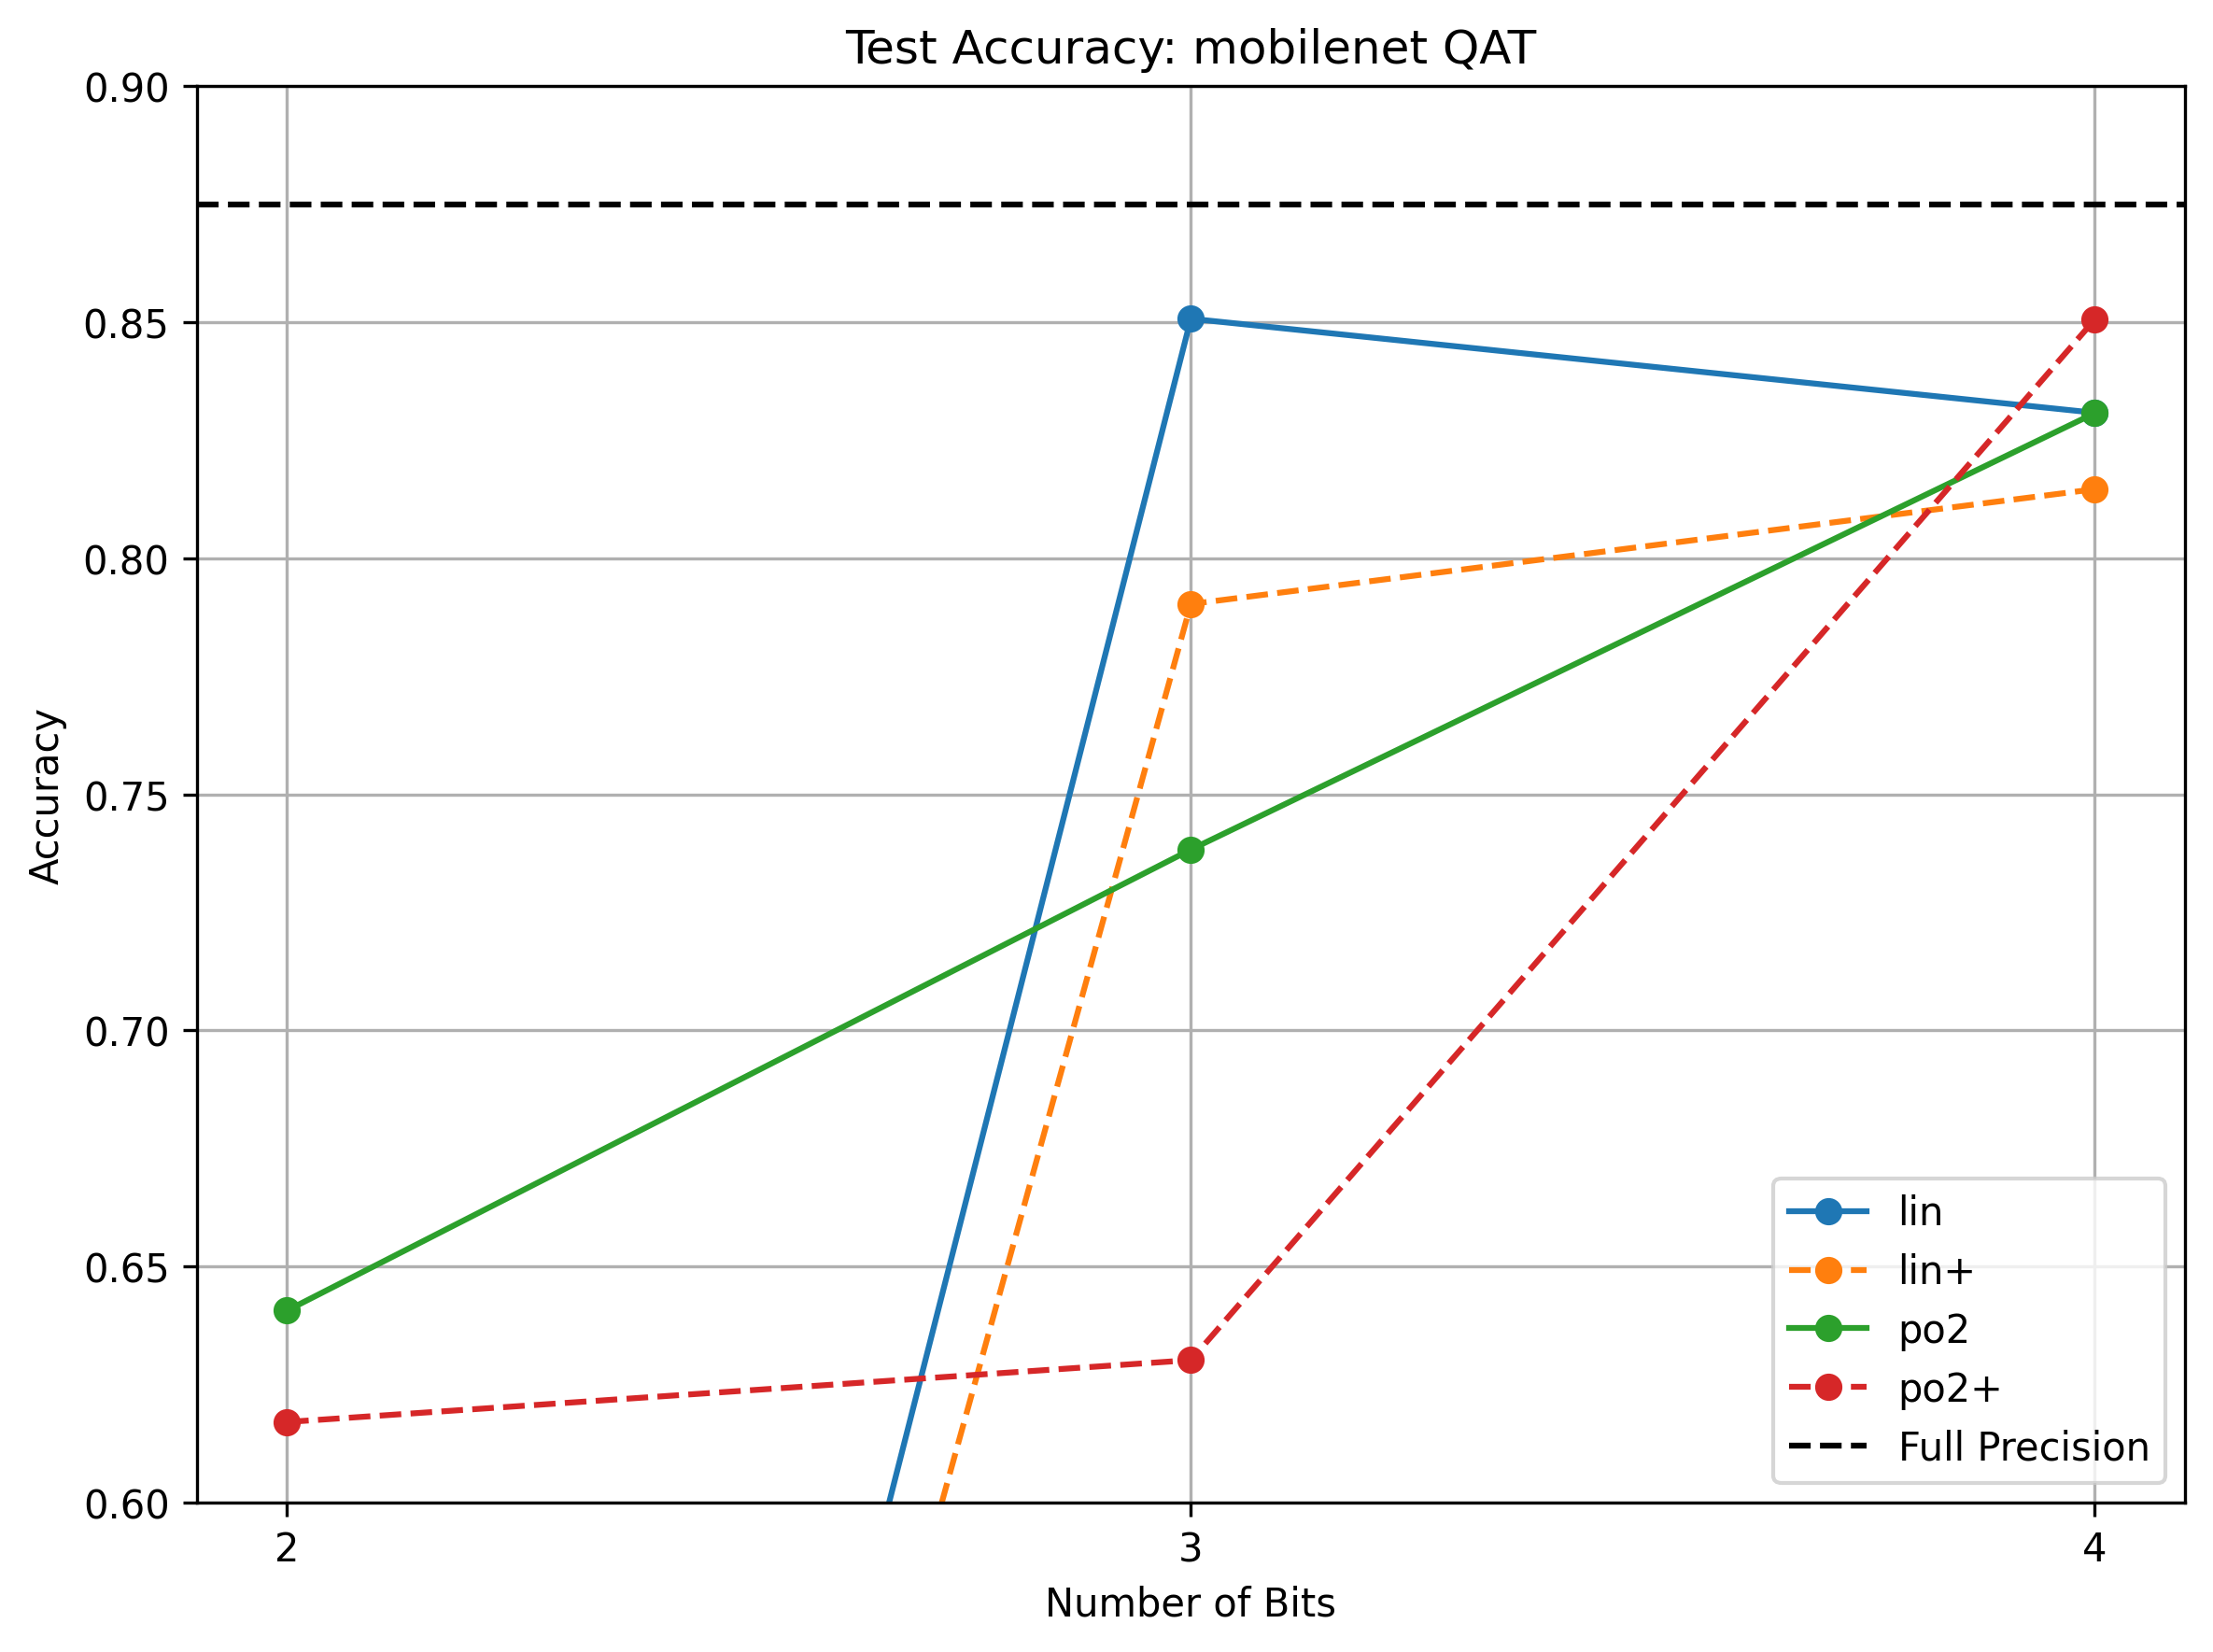

In [203]:
df5 = get_results("mobilenet", 0.6, 0.9, qat=True)

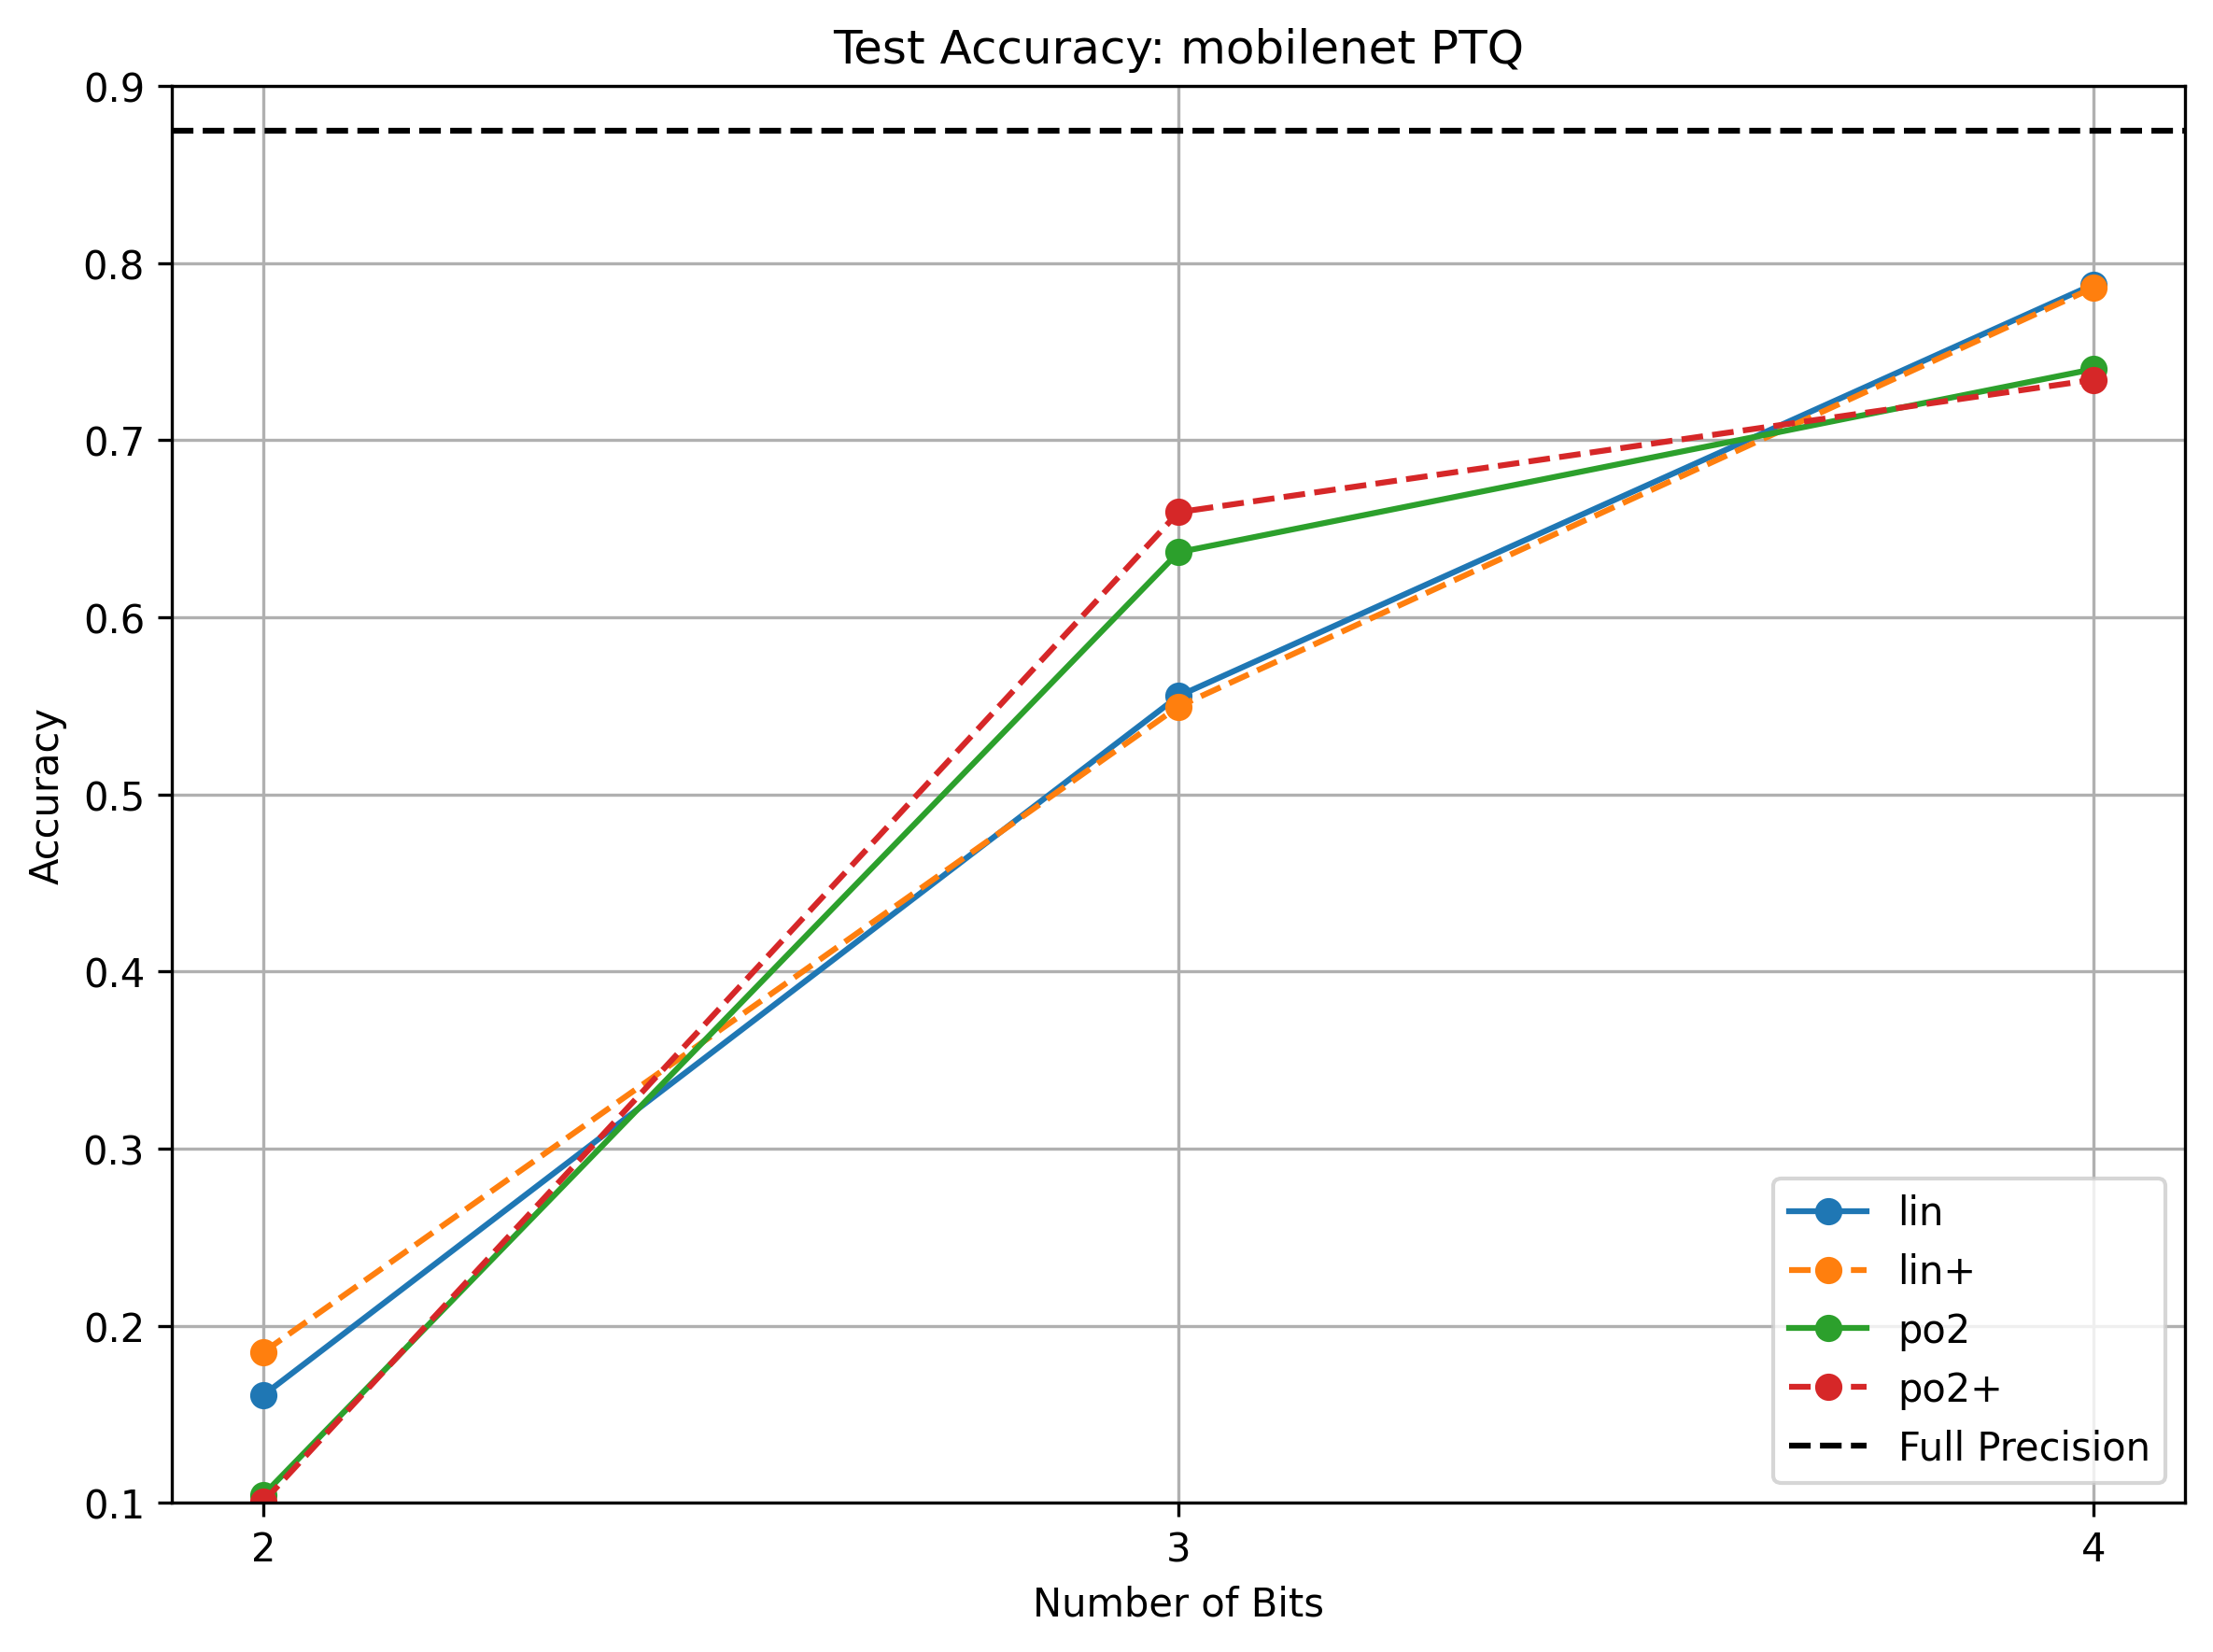

In [204]:
_ = get_results("mobilenet", 0.1, 0.9, qat=False)

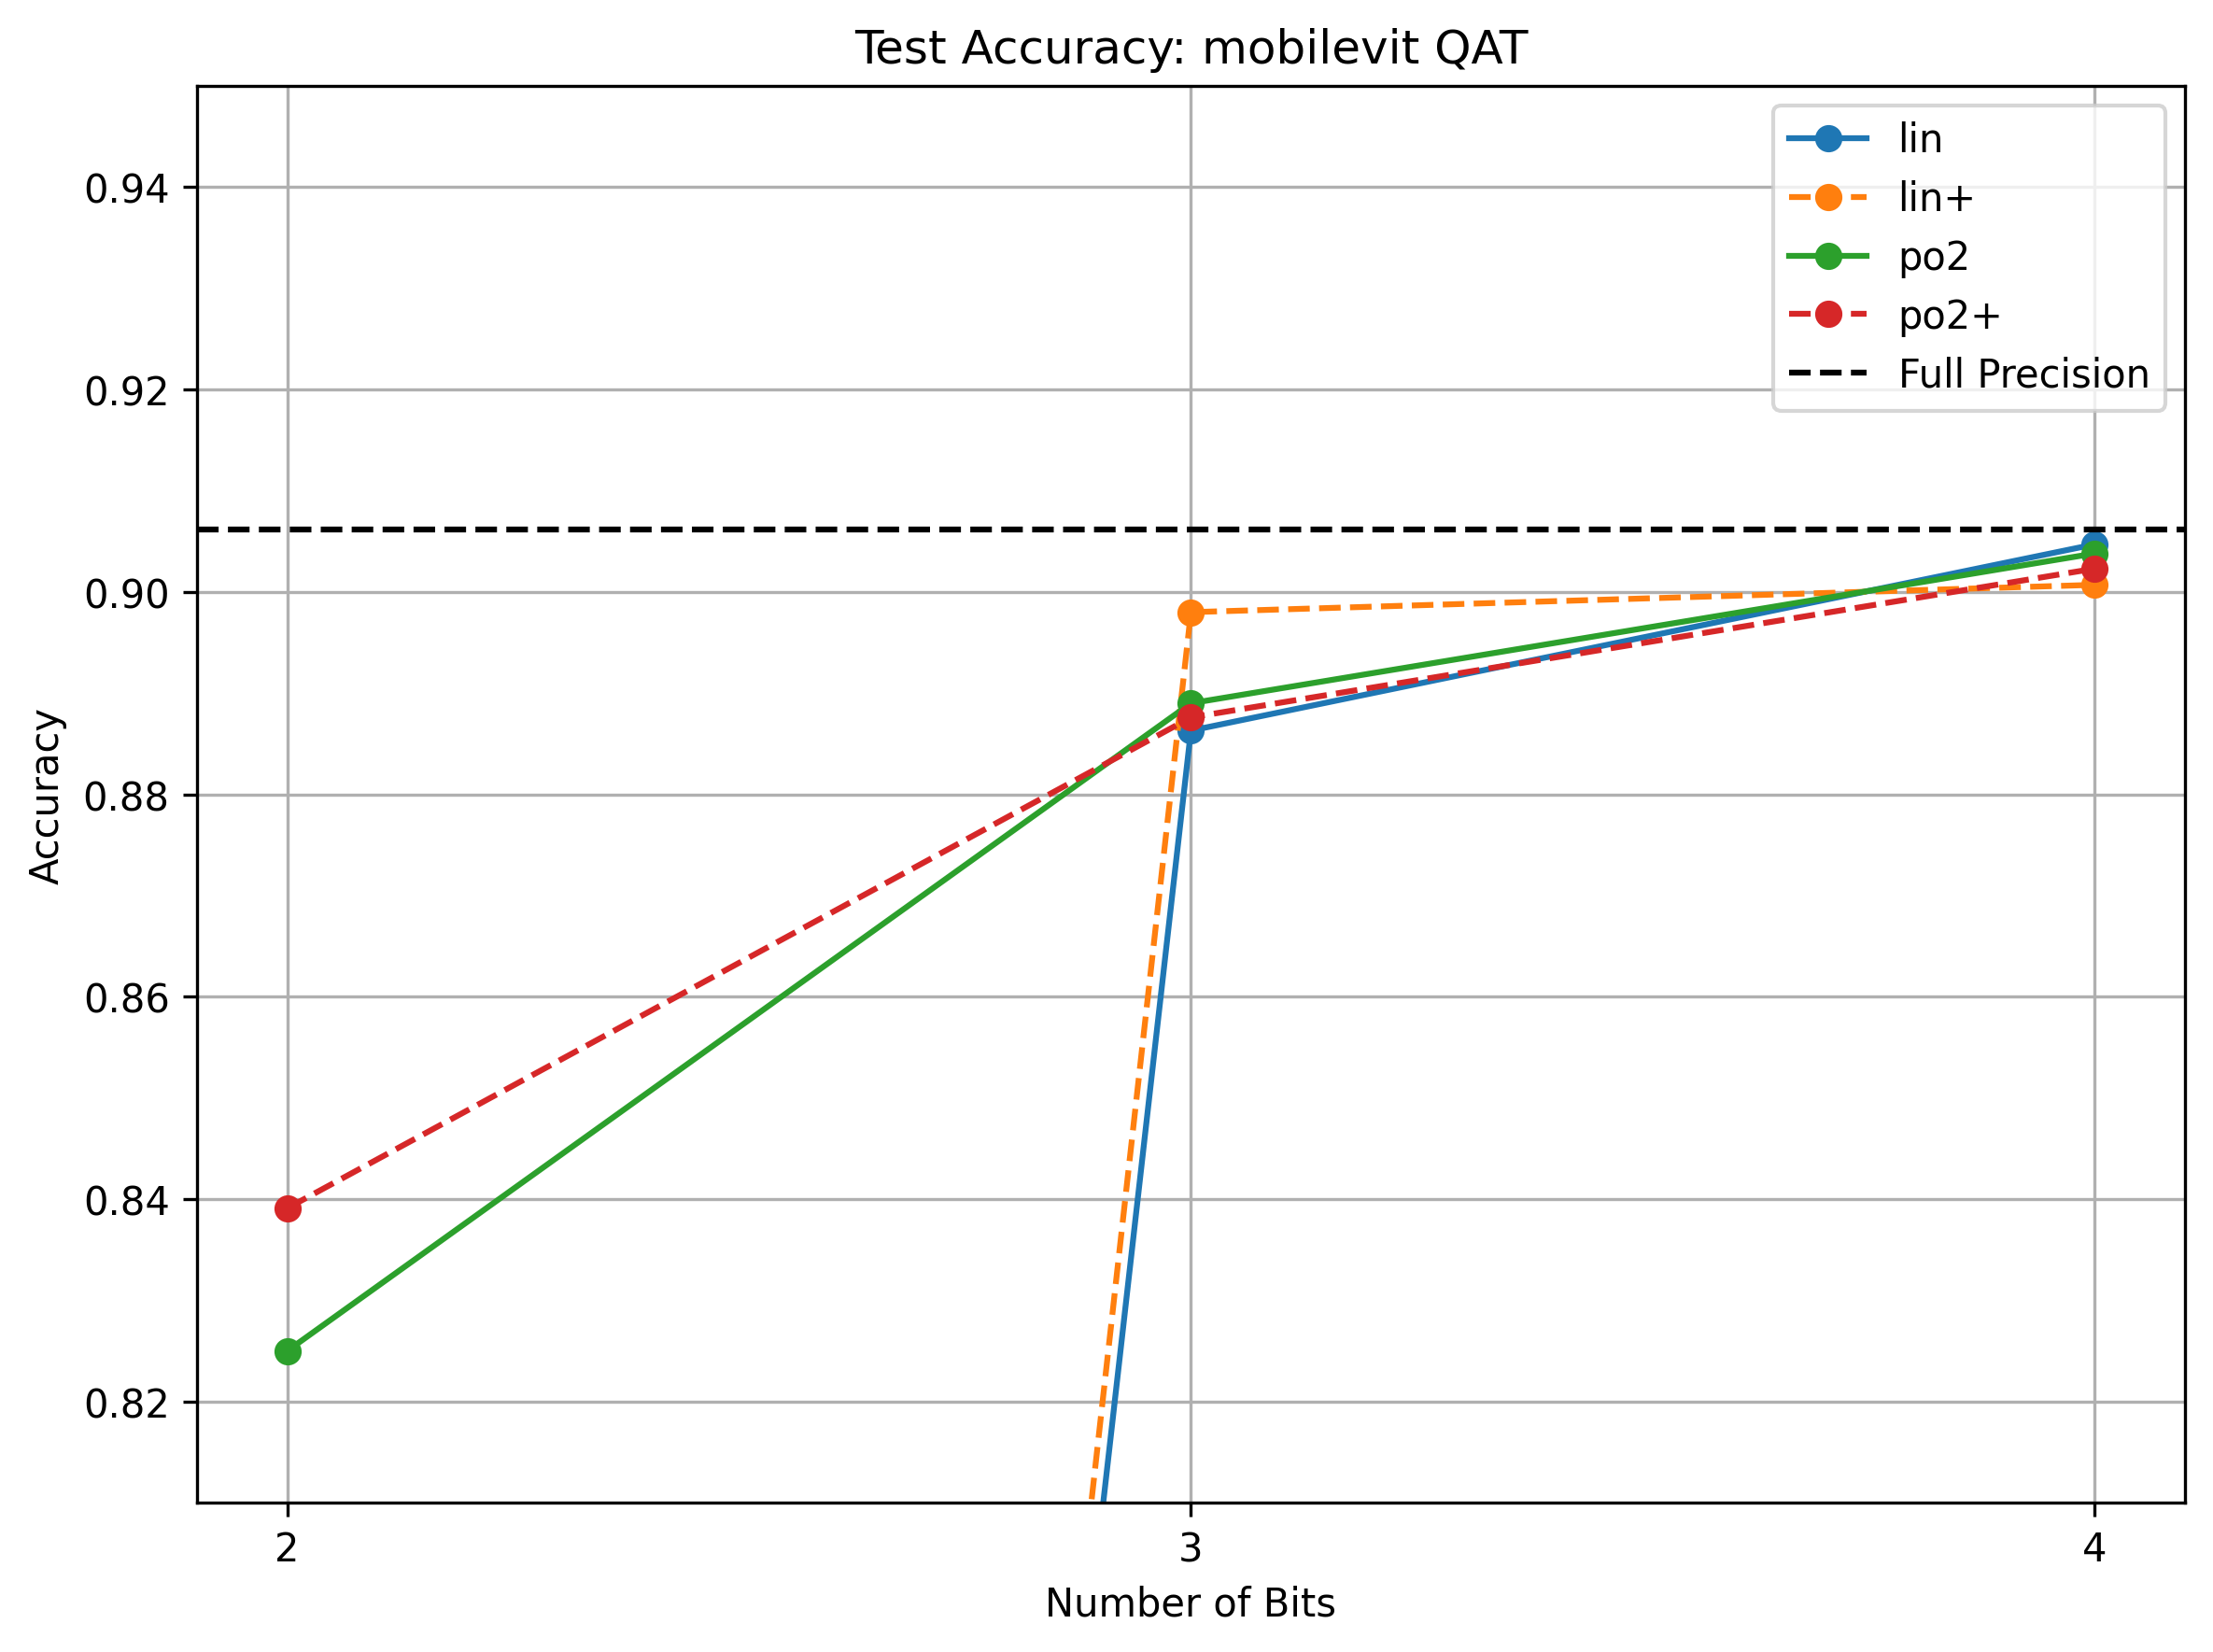

In [205]:
df6 = get_results("mobilevit", 0.81, 0.95, qat=True)

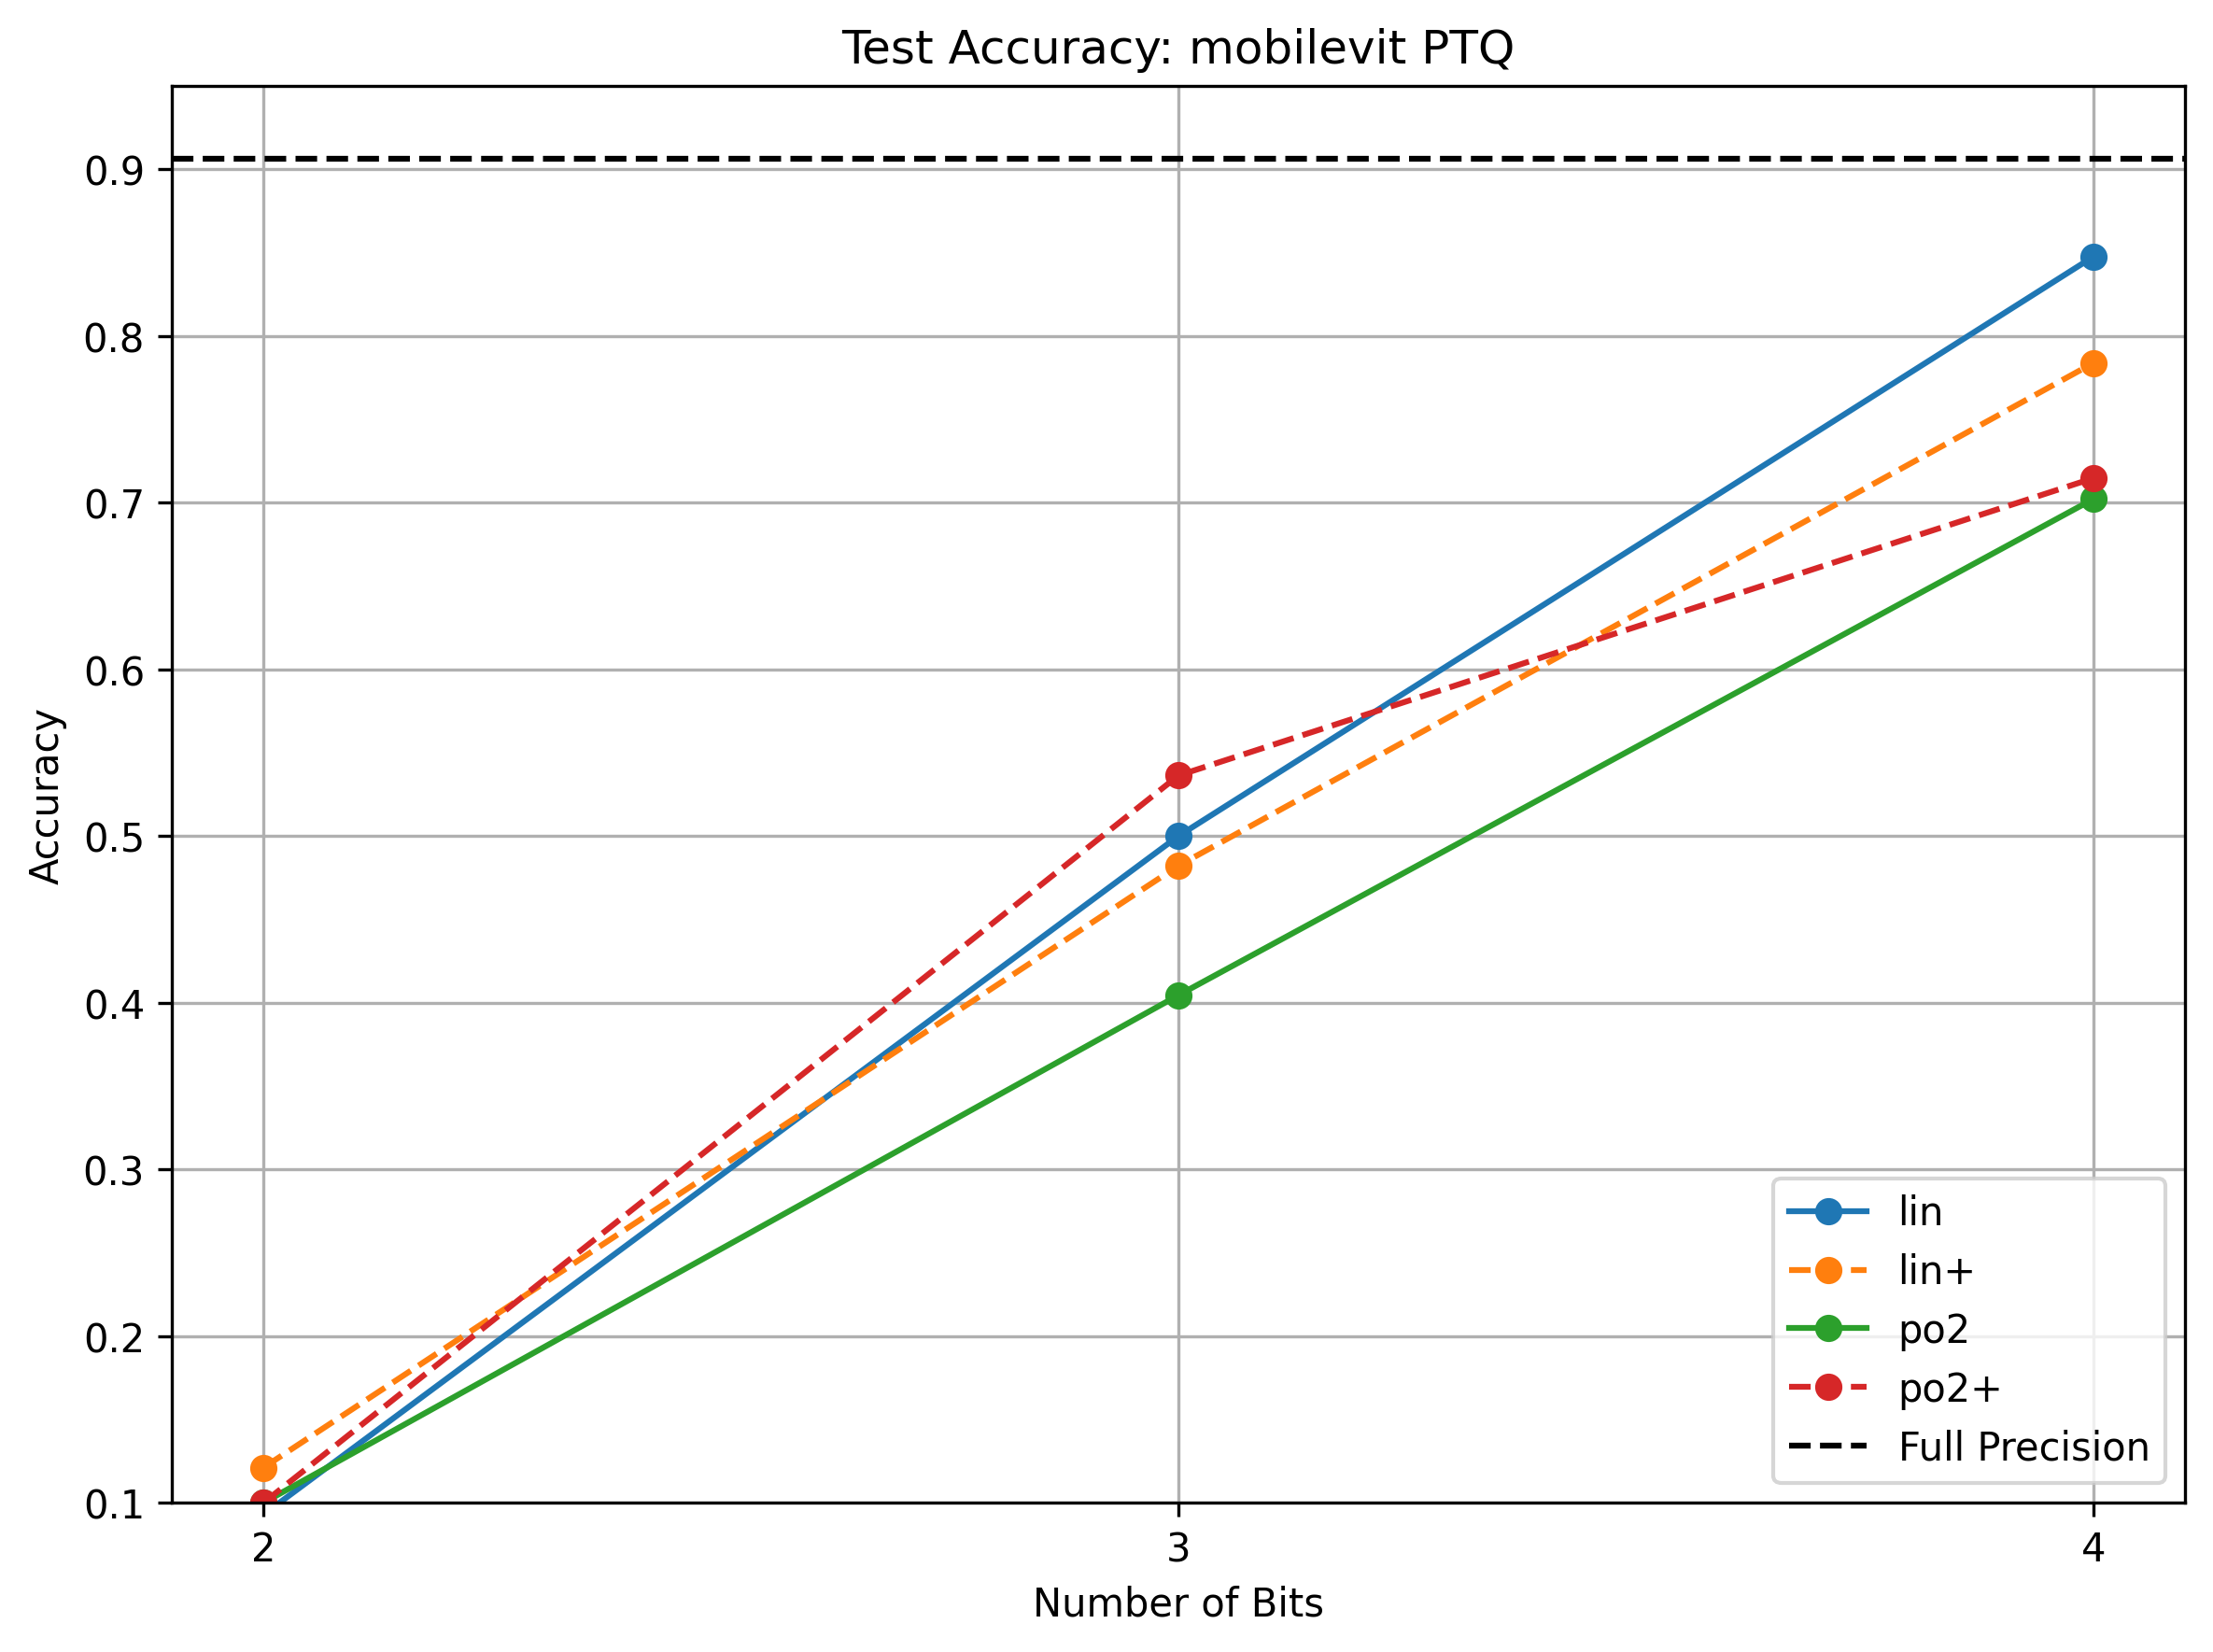

In [206]:
_ = get_results("mobilevit", 0.1, 0.95, qat=False)